## Installation

In [ ]:
! pip install wyn-keras

In [ ]:
! pip install medmnist

## Acquire Data

In [ ]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

In [ ]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.2 @ https://github.com/MedMNIST/MedMNIST/


We first work on a 2D dataset with size 28x28

In [ ]:
data_flag = 'pathmnist'
# data_flag = 'breastmnist'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

First, we read the MedMNIST data, preprocess them and encapsulate them into dataloader form.

In [ ]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Using downloaded and verified file: /root/.medmnist/pathmnist.npz


In [ ]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset PathMNIST of size 28 (pathmnist)
    Number of datapoints: 89996
    Root location: /root/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}
    Number of samples: {'train': 89996, 'val': 10004, 'test': 7180}
    Description: The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE-100K

In [ ]:
# visualization

train_dataset.montage(length=1)

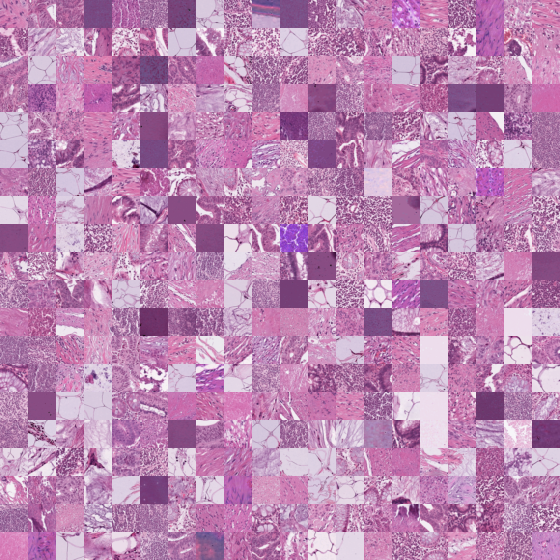

In [ ]:
# montage

train_dataset.montage(length=20)

Convert dimensions

In [ ]:
for inputs, targets in tqdm(train_loader):
    print(inputs.shape, targets.shape)
    break

  0%|          | 0/704 [00:00<?, ?it/s]

torch.Size([128, 3, 28, 28]) torch.Size([128, 1])


In [ ]:
import torch

def rearrange_tensor(input_tensor: torch.Tensor) -> torch.Tensor:
    """
    Rearrange the given input tensor from (B, C, H, W) to (B, H, W, C).

    Args:
        input_tensor (torch.Tensor): A PyTorch tensor in the shape (B, C, H, W).

    Returns:
        torch.Tensor: The rearranged tensor in the shape (B, H, W, C).
    """
    # permute changes the ordering of dimensions
    # here, we move the channel dimension (C) to the end
    # effectively going from (B, C, H, W) --> (B, H, W, C)
    output_tensor = input_tensor.permute(0, 2, 3, 1)
    return output_tensor

In [ ]:
X = rearrange_tensor(inputs)
print(X.shape)

torch.Size([128, 28, 28, 3])


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def plot_random_images(
    images: np.ndarray,
    targets: torch.Tensor
) -> None:
    """
    Plots 10 random images from a batch of images arranged in a grid,
    displaying each image along with its label as the title.

    Args:
        images (np.ndarray):
            A numpy array of shape (batch_size, height, width, channels).
            Example shape: (128, 28, 28, 3).

        targets (torch.Tensor):
            A PyTorch tensor of shape (batch_size, 1) (or (batch_size,)),
            containing the labels for each image.

    Returns:
        None
    """
    # Select 10 random indices without replacement
    random_indices = np.random.choice(images.shape[0], size=10, replace=False)

    # Create a 2x5 grid for plotting
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 6))
    axes = axes.flatten()  # Flatten the axes for easier handling

    # Loop over the chosen indices and plot each image with its label
    for i, idx in enumerate(random_indices):
        axes[i].imshow(images[idx])
        # Convert the single-element label to a Python int
        label_value = targets[idx].item()
        axes[i].set_title(f"label: {label_value}")
        axes[i].axis('off')  # Hide the axis to make the image clearer

    plt.tight_layout()
    plt.show()

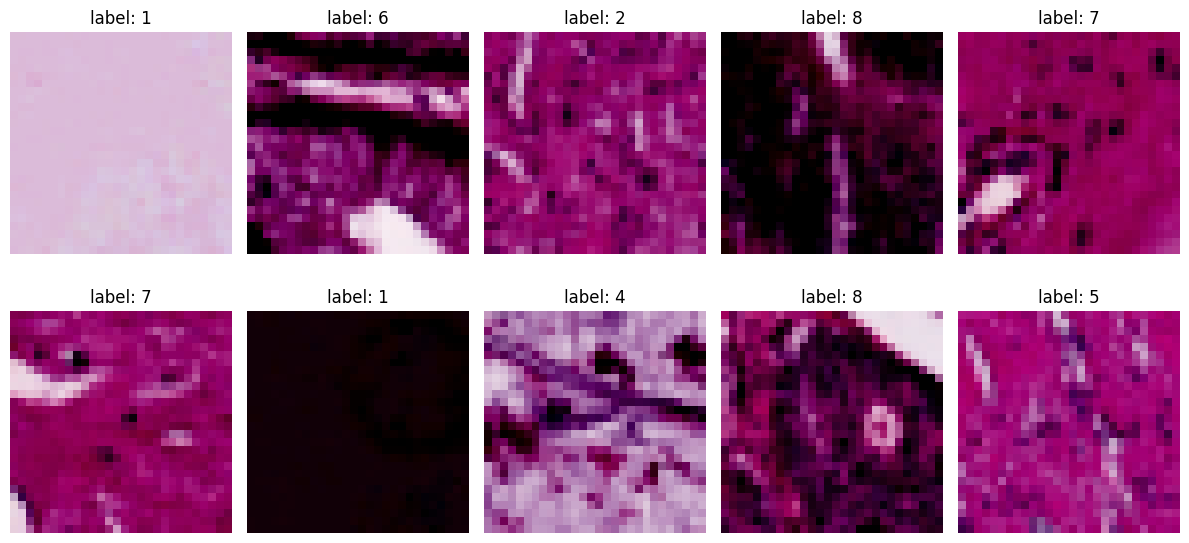

In [ ]:
plot_random_images(X.numpy(), targets)

In [ ]:
print(type(X), type(targets))

<class 'torch.Tensor'> <class 'torch.Tensor'>


In [ ]:
X = X.numpy()
y = targets.numpy()

print(type(X), type(y))
print(X.shape, y.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(128, 28, 28, 3) (128, 1)


In [ ]:
from wyn_keras.vit import ViT
from sklearn.model_selection import train_test_split

In [ ]:
# Create an instance of the ViT class
num_classes = np.unique(targets).shape[0]
print(num_classes)

vit_model = ViT(num_classes=num_classes, input_shape=(28, 28, 3), image_size=32, patch_size=8, num_epochs=20)

9


In [ ]:
for inputs, targets in tqdm(train_loader):

    # Get
    X = rearrange_tensor(inputs)
    X = X.numpy()
    y = targets.numpy()

    # Train test split
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

    # Create the ViT model
    model = vit_model.create_vit_classifier()

    # Train the model
    history = vit_model.run_experiment(model, x_train, y_train, x_test, y_test)

  0%|          | 0/704 [00:00<?, ?it/s]

Epoch 1/20
1/1 [==============================] - 24s 24s/step - loss: 3.0838 - accuracy: 0.1068 - top-5-accuracy: 0.5728 - val_loss: 2.7232 - val_accuracy: 0.0833 - val_top-5-accuracy: 0.5000
Epoch 2/20
1/1 [==============================] - 1s 1s/step - loss: 3.2810 - accuracy: 0.1650 - top-5-accuracy: 0.4854 - val_loss: 2.1905 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.5833
Epoch 3/20
1/1 [==============================] - 1s 719ms/step - loss: 3.1598 - accuracy: 0.1650 - top-5-accuracy: 0.6408 - val_loss: 2.3133 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.5833
Epoch 4/20
1/1 [==============================] - 1s 811ms/step - loss: 2.5168 - accuracy: 0.2136 - top-5-accuracy: 0.6990 - val_loss: 2.3185 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.6667
Epoch 5/20
1/1 [==============================] - 1s 813ms/step - loss: 2.4750 - accuracy: 0.2330 - top-5-accuracy: 0.6990 - val_loss: 2.1907 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.5833
Epoch 6/20
1/1 [==================

  0%|          | 1/704 [01:05<12:48:44, 65.61s/it]

Test accuracy: 15.38%
Test top 5 accuracy: 61.54%
Epoch 1/20
1/1 [==============================] - 23s 23s/step - loss: 3.0855 - accuracy: 0.1165 - top-5-accuracy: 0.5922 - val_loss: 2.3524 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.6667
Epoch 2/20
1/1 [==============================] - 1s 860ms/step - loss: 2.8422 - accuracy: 0.2330 - top-5-accuracy: 0.7087 - val_loss: 2.5971 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.5833
Epoch 3/20
1/1 [==============================] - 1s 1s/step - loss: 3.1782 - accuracy: 0.2136 - top-5-accuracy: 0.6602 - val_loss: 1.8511 - val_accuracy: 0.4167 - val_top-5-accuracy: 0.6667
Epoch 4/20
1/1 [==============================] - 1s 781ms/step - loss: 2.6702 - accuracy: 0.2524 - top-5-accuracy: 0.6602 - val_loss: 1.8228 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.8333
Epoch 5/20
1/1 [==============================] - 1s 772ms/step - loss: 2.5632 - accuracy: 0.3107 - top-5-accuracy: 0.6311 - val_loss: 1.9182 - val_accuracy: 0.4167 - val_top-5-a

  0%|          | 2/704 [01:49<10:19:12, 52.92s/it]

Test accuracy: 46.15%
Test top 5 accuracy: 92.31%
Epoch 1/20
1/1 [==============================] - 23s 23s/step - loss: 3.5379 - accuracy: 0.0874 - top-5-accuracy: 0.5146 - val_loss: 2.2304 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.7500
Epoch 2/20
1/1 [==============================] - 1s 837ms/step - loss: 3.0479 - accuracy: 0.1748 - top-5-accuracy: 0.6990 - val_loss: 2.0763 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.7500
Epoch 3/20
1/1 [==============================] - 1s 1s/step - loss: 3.3263 - accuracy: 0.1456 - top-5-accuracy: 0.6019 - val_loss: 1.8571 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.7500
Epoch 4/20
1/1 [==============================] - 1s 791ms/step - loss: 2.6449 - accuracy: 0.2136 - top-5-accuracy: 0.6602 - val_loss: 2.2738 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.6667
Epoch 5/20
1/1 [==============================] - 1s 1s/step - loss: 2.5796 - accuracy: 0.2621 - top-5-accuracy: 0.7476 - val_loss: 1.8666 - val_accuracy: 0.3333 - val_top-5-accu

  0%|          | 3/704 [02:53<11:16:05, 57.87s/it]

Test accuracy: 53.85%
Test top 5 accuracy: 100.00%
Epoch 1/20
1/1 [==============================] - 24s 24s/step - loss: 3.0148 - accuracy: 0.1262 - top-5-accuracy: 0.6214 - val_loss: 2.9478 - val_accuracy: 0.0833 - val_top-5-accuracy: 0.4167
Epoch 2/20
1/1 [==============================] - 1s 1s/step - loss: 3.1589 - accuracy: 0.1845 - top-5-accuracy: 0.7087 - val_loss: 2.4092 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.6667
Epoch 3/20
1/1 [==============================] - 1s 732ms/step - loss: 3.2103 - accuracy: 0.1845 - top-5-accuracy: 0.6505 - val_loss: 2.2282 - val_accuracy: 0.0833 - val_top-5-accuracy: 0.5833
Epoch 4/20
1/1 [==============================] - 1s 755ms/step - loss: 2.9605 - accuracy: 0.2233 - top-5-accuracy: 0.6893 - val_loss: 2.0438 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.7500
Epoch 5/20
1/1 [==============================] - 1s 1s/step - loss: 2.8154 - accuracy: 0.1650 - top-5-accuracy: 0.7573 - val_loss: 1.6937 - val_accuracy: 0.3333 - val_top-5-acc

  1%|          | 4/704 [03:55<11:34:42, 59.55s/it]

Test accuracy: 15.38%
Test top 5 accuracy: 76.92%
Epoch 1/20
1/1 [==============================] - 22s 22s/step - loss: 3.1444 - accuracy: 0.1748 - top-5-accuracy: 0.5534 - val_loss: 2.0219 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.8333
Epoch 2/20
1/1 [==============================] - 1s 1s/step - loss: 3.2750 - accuracy: 0.1650 - top-5-accuracy: 0.6117 - val_loss: 2.7372 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.5833
Epoch 3/20
1/1 [==============================] - 1s 1s/step - loss: 3.1116 - accuracy: 0.2136 - top-5-accuracy: 0.6408 - val_loss: 2.0953 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.6667
Epoch 4/20
1/1 [==============================] - 1s 788ms/step - loss: 2.7304 - accuracy: 0.1748 - top-5-accuracy: 0.6019 - val_loss: 2.5626 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.7500
Epoch 5/20
1/1 [==============================] - 1s 773ms/step - loss: 2.8928 - accuracy: 0.2427 - top-5-accuracy: 0.7087 - val_loss: 2.2115 - val_accuracy: 0.0833 - val_top-5-accu

  1%|          | 5/704 [04:57<11:44:13, 60.45s/it]

Test accuracy: 23.08%
Test top 5 accuracy: 76.92%
Epoch 1/20
1/1 [==============================] - 24s 24s/step - loss: 3.5823 - accuracy: 0.0680 - top-5-accuracy: 0.5243 - val_loss: 2.4482 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.6667
Epoch 2/20
1/1 [==============================] - 1s 1s/step - loss: 3.3470 - accuracy: 0.1359 - top-5-accuracy: 0.7087 - val_loss: 1.7742 - val_accuracy: 0.4167 - val_top-5-accuracy: 0.7500
Epoch 3/20
1/1 [==============================] - 1s 1s/step - loss: 3.4611 - accuracy: 0.1553 - top-5-accuracy: 0.5825 - val_loss: 1.9272 - val_accuracy: 0.4167 - val_top-5-accuracy: 0.6667
Epoch 4/20
1/1 [==============================] - 1s 1s/step - loss: 2.5791 - accuracy: 0.2039 - top-5-accuracy: 0.7476 - val_loss: 2.5190 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.7500
Epoch 5/20
1/1 [==============================] - 1s 1s/step - loss: 2.5591 - accuracy: 0.2427 - top-5-accuracy: 0.6990 - val_loss: 1.9193 - val_accuracy: 0.3333 - val_top-5-accuracy: 

  1%|          | 6/704 [05:43<10:44:20, 55.39s/it]

Test accuracy: 30.77%
Test top 5 accuracy: 84.62%
Epoch 1/20
1/1 [==============================] - 23s 23s/step - loss: 3.0768 - accuracy: 0.1845 - top-5-accuracy: 0.5825 - val_loss: 2.2050 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.7500
Epoch 2/20
1/1 [==============================] - 2s 2s/step - loss: 3.2180 - accuracy: 0.1942 - top-5-accuracy: 0.6408 - val_loss: 2.3314 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.5833
Epoch 3/20
1/1 [==============================] - 1s 772ms/step - loss: 2.9016 - accuracy: 0.2427 - top-5-accuracy: 0.6311 - val_loss: 2.1688 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.5000
Epoch 4/20
1/1 [==============================] - 1s 733ms/step - loss: 2.7154 - accuracy: 0.1748 - top-5-accuracy: 0.6214 - val_loss: 1.9009 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.9167
Epoch 5/20
1/1 [==============================] - 1s 742ms/step - loss: 2.4051 - accuracy: 0.2039 - top-5-accuracy: 0.6990 - val_loss: 1.4319 - val_accuracy: 0.3333 - val_top-5-a

  1%|          | 7/704 [06:44<11:07:19, 57.44s/it]

Test accuracy: 38.46%
Test top 5 accuracy: 84.62%
Epoch 1/20
1/1 [==============================] - 21s 21s/step - loss: 3.0468 - accuracy: 0.1359 - top-5-accuracy: 0.6019 - val_loss: 2.1115 - val_accuracy: 0.4167 - val_top-5-accuracy: 0.5833
Epoch 2/20
1/1 [==============================] - 1s 762ms/step - loss: 2.9491 - accuracy: 0.1748 - top-5-accuracy: 0.7282 - val_loss: 1.7026 - val_accuracy: 0.4167 - val_top-5-accuracy: 0.8333
Epoch 3/20
1/1 [==============================] - 1s 771ms/step - loss: 3.1850 - accuracy: 0.2136 - top-5-accuracy: 0.6699 - val_loss: 1.3706 - val_accuracy: 0.3333 - val_top-5-accuracy: 1.0000
Epoch 4/20
1/1 [==============================] - 1s 760ms/step - loss: 2.2410 - accuracy: 0.2913 - top-5-accuracy: 0.7961 - val_loss: 1.6534 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.9167
Epoch 5/20
1/1 [==============================] - 1s 1s/step - loss: 2.7394 - accuracy: 0.3107 - top-5-accuracy: 0.7961 - val_loss: 1.1891 - val_accuracy: 0.5000 - val_top-5-a

  1%|          | 8/704 [07:27<10:10:13, 52.61s/it]

Test accuracy: 23.08%
Test top 5 accuracy: 84.62%
Epoch 1/20
1/1 [==============================] - 24s 24s/step - loss: 3.2222 - accuracy: 0.0680 - top-5-accuracy: 0.5340 - val_loss: 2.2475 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.8333
Epoch 2/20
1/1 [==============================] - 1s 852ms/step - loss: 3.2776 - accuracy: 0.1553 - top-5-accuracy: 0.6602 - val_loss: 2.8846 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.6667
Epoch 3/20
1/1 [==============================] - 1s 778ms/step - loss: 2.8964 - accuracy: 0.2913 - top-5-accuracy: 0.6990 - val_loss: 2.4583 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.7500
Epoch 4/20
1/1 [==============================] - 1s 795ms/step - loss: 3.9485 - accuracy: 0.1845 - top-5-accuracy: 0.5340 - val_loss: 1.8207 - val_accuracy: 0.1667 - val_top-5-accuracy: 1.0000
Epoch 5/20
1/1 [==============================] - 1s 1s/step - loss: 2.7632 - accuracy: 0.1845 - top-5-accuracy: 0.6602 - val_loss: 2.7071 - val_accuracy: 0.1667 - val_top-5-a

  1%|▏         | 9/704 [08:11<9:39:29, 50.03s/it] 

Test accuracy: 23.08%
Test top 5 accuracy: 76.92%
Epoch 1/20
1/1 [==============================] - 21s 21s/step - loss: 2.8330 - accuracy: 0.1748 - top-5-accuracy: 0.6311 - val_loss: 2.7824 - val_accuracy: 0.0000e+00 - val_top-5-accuracy: 0.5000
Epoch 2/20
1/1 [==============================] - 1s 1s/step - loss: 3.0247 - accuracy: 0.2136 - top-5-accuracy: 0.7282 - val_loss: 2.5602 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.6667
Epoch 3/20
1/1 [==============================] - 1s 1s/step - loss: 3.3918 - accuracy: 0.2039 - top-5-accuracy: 0.5631 - val_loss: 2.0344 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.8333
Epoch 4/20
1/1 [==============================] - 1s 1s/step - loss: 2.8994 - accuracy: 0.1748 - top-5-accuracy: 0.6699 - val_loss: 2.8231 - val_accuracy: 0.0000e+00 - val_top-5-accuracy: 0.6667
Epoch 5/20
1/1 [==============================] - 1s 1s/step - loss: 2.9166 - accuracy: 0.2233 - top-5-accuracy: 0.7184 - val_loss: 2.2085 - val_accuracy: 0.2500 - val_top-5-ac

  1%|▏         | 10/704 [09:12<10:19:42, 53.58s/it]

Test accuracy: 53.85%
Test top 5 accuracy: 76.92%
Epoch 1/20
1/1 [==============================] - 20s 20s/step - loss: 3.5579 - accuracy: 0.0680 - top-5-accuracy: 0.4757 - val_loss: 2.7992 - val_accuracy: 0.0833 - val_top-5-accuracy: 0.5000
Epoch 2/20
1/1 [==============================] - 1s 1s/step - loss: 3.3018 - accuracy: 0.2136 - top-5-accuracy: 0.6990 - val_loss: 2.4664 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.7500
Epoch 3/20
1/1 [==============================] - 1s 748ms/step - loss: 2.8927 - accuracy: 0.1456 - top-5-accuracy: 0.7087 - val_loss: 3.7512 - val_accuracy: 0.0833 - val_top-5-accuracy: 0.6667
Epoch 4/20
1/1 [==============================] - 1s 643ms/step - loss: 3.1941 - accuracy: 0.2913 - top-5-accuracy: 0.6699 - val_loss: 2.4309 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.7500
Epoch 5/20
1/1 [==============================] - 1s 633ms/step - loss: 3.3655 - accuracy: 0.1942 - top-5-accuracy: 0.6796 - val_loss: 1.9847 - val_accuracy: 0.2500 - val_top-5-a

  2%|▏         | 11/704 [10:13<10:43:34, 55.72s/it]

Test accuracy: 15.38%
Test top 5 accuracy: 76.92%
Epoch 1/20
1/1 [==============================] - 22s 22s/step - loss: 3.1677 - accuracy: 0.1068 - top-5-accuracy: 0.5631 - val_loss: 2.7223 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.6667
Epoch 2/20
1/1 [==============================] - 1s 1s/step - loss: 3.0679 - accuracy: 0.1845 - top-5-accuracy: 0.7184 - val_loss: 3.3216 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.5833
Epoch 3/20
1/1 [==============================] - 1s 779ms/step - loss: 3.7054 - accuracy: 0.1650 - top-5-accuracy: 0.5825 - val_loss: 3.3207 - val_accuracy: 0.0833 - val_top-5-accuracy: 0.5000
Epoch 4/20
1/1 [==============================] - 1s 780ms/step - loss: 3.2111 - accuracy: 0.1650 - top-5-accuracy: 0.5825 - val_loss: 2.9445 - val_accuracy: 0.0833 - val_top-5-accuracy: 0.5833
Epoch 5/20
1/1 [==============================] - 1s 723ms/step - loss: 3.0887 - accuracy: 0.1942 - top-5-accuracy: 0.6505 - val_loss: 2.4905 - val_accuracy: 0.1667 - val_top-5-a

  2%|▏         | 12/704 [10:54<9:52:36, 51.38s/it] 

Test accuracy: 7.69%
Test top 5 accuracy: 76.92%
Epoch 1/20
1/1 [==============================] - 19s 19s/step - loss: 2.8750 - accuracy: 0.1553 - top-5-accuracy: 0.6311 - val_loss: 1.9364 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.7500
Epoch 2/20
1/1 [==============================] - 2s 2s/step - loss: 2.7835 - accuracy: 0.2039 - top-5-accuracy: 0.6505 - val_loss: 2.4365 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.5833
Epoch 3/20
1/1 [==============================] - 3s 3s/step - loss: 3.3128 - accuracy: 0.2136 - top-5-accuracy: 0.6699 - val_loss: 1.4654 - val_accuracy: 0.5000 - val_top-5-accuracy: 0.8333
Epoch 4/20
1/1 [==============================] - 1s 655ms/step - loss: 3.2610 - accuracy: 0.1068 - top-5-accuracy: 0.6214 - val_loss: 1.4364 - val_accuracy: 0.5000 - val_top-5-accuracy: 0.8333
Epoch 5/20
1/1 [==============================] - 1s 705ms/step - loss: 3.0939 - accuracy: 0.2913 - top-5-accuracy: 0.6408 - val_loss: 1.4256 - val_accuracy: 0.3333 - val_top-5-accur

  2%|▏         | 13/704 [11:34<9:09:50, 47.74s/it]

Test accuracy: 38.46%
Test top 5 accuracy: 69.23%
Epoch 1/20
1/1 [==============================] - 19s 19s/step - loss: 3.2170 - accuracy: 0.1068 - top-5-accuracy: 0.5728 - val_loss: 2.1800 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.6667
Epoch 2/20
1/1 [==============================] - 1s 796ms/step - loss: 2.9668 - accuracy: 0.1845 - top-5-accuracy: 0.6699 - val_loss: 4.1740 - val_accuracy: 0.0833 - val_top-5-accuracy: 0.4167
Epoch 3/20
1/1 [==============================] - 1s 892ms/step - loss: 3.5596 - accuracy: 0.1650 - top-5-accuracy: 0.6602 - val_loss: 2.8572 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.6667
Epoch 4/20
1/1 [==============================] - 1s 1s/step - loss: 3.4668 - accuracy: 0.1553 - top-5-accuracy: 0.6019 - val_loss: 1.9363 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.9167
Epoch 5/20
1/1 [==============================] - 1s 1s/step - loss: 2.7042 - accuracy: 0.2718 - top-5-accuracy: 0.6602 - val_loss: 2.0171 - val_accuracy: 0.3333 - val_top-5-accu

  2%|▏         | 14/704 [12:10<8:29:19, 44.29s/it]

Test accuracy: 30.77%
Test top 5 accuracy: 84.62%
Epoch 1/20
1/1 [==============================] - 22s 22s/step - loss: 3.2381 - accuracy: 0.1068 - top-5-accuracy: 0.5825 - val_loss: 2.5892 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.6667
Epoch 2/20
1/1 [==============================] - 1s 720ms/step - loss: 3.7699 - accuracy: 0.2039 - top-5-accuracy: 0.6019 - val_loss: 2.7127 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.5833
Epoch 3/20
1/1 [==============================] - 1s 707ms/step - loss: 3.4888 - accuracy: 0.1845 - top-5-accuracy: 0.6019 - val_loss: 2.7806 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.5833
Epoch 4/20
1/1 [==============================] - 1s 1s/step - loss: 2.5064 - accuracy: 0.2233 - top-5-accuracy: 0.7379 - val_loss: 2.4404 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.6667
Epoch 5/20
1/1 [==============================] - 2s 2s/step - loss: 2.8205 - accuracy: 0.2718 - top-5-accuracy: 0.6796 - val_loss: 1.8621 - val_accuracy: 0.4167 - val_top-5-accu

  2%|▏         | 15/704 [12:51<8:15:10, 43.12s/it]

Test accuracy: 15.38%
Test top 5 accuracy: 76.92%
Epoch 1/20
1/1 [==============================] - 19s 19s/step - loss: 3.3434 - accuracy: 0.0874 - top-5-accuracy: 0.5631 - val_loss: 2.4222 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.6667
Epoch 2/20
1/1 [==============================] - 1s 1s/step - loss: 3.0517 - accuracy: 0.2330 - top-5-accuracy: 0.7184 - val_loss: 2.7343 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.5000
Epoch 3/20
1/1 [==============================] - 1s 629ms/step - loss: 2.9462 - accuracy: 0.2233 - top-5-accuracy: 0.6699 - val_loss: 2.2339 - val_accuracy: 0.0833 - val_top-5-accuracy: 0.8333
Epoch 4/20
1/1 [==============================] - 1s 671ms/step - loss: 2.6336 - accuracy: 0.2233 - top-5-accuracy: 0.7476 - val_loss: 1.6999 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.9167
Epoch 5/20
1/1 [==============================] - 1s 657ms/step - loss: 2.3100 - accuracy: 0.3010 - top-5-accuracy: 0.7864 - val_loss: 2.1003 - val_accuracy: 0.1667 - val_top-5-a

  2%|▏         | 16/704 [13:31<8:04:35, 42.26s/it]

Test accuracy: 30.77%
Test top 5 accuracy: 61.54%
Epoch 1/20
1/1 [==============================] - 21s 21s/step - loss: 3.5185 - accuracy: 0.0874 - top-5-accuracy: 0.4563 - val_loss: 3.7444 - val_accuracy: 0.0000e+00 - val_top-5-accuracy: 0.5000
Epoch 2/20
1/1 [==============================] - 1s 1s/step - loss: 3.2005 - accuracy: 0.1942 - top-5-accuracy: 0.7379 - val_loss: 2.1017 - val_accuracy: 0.0833 - val_top-5-accuracy: 0.6667
Epoch 3/20
1/1 [==============================] - 1s 1s/step - loss: 3.0413 - accuracy: 0.2330 - top-5-accuracy: 0.6893 - val_loss: 1.9537 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.8333
Epoch 4/20
1/1 [==============================] - 1s 659ms/step - loss: 2.7951 - accuracy: 0.2330 - top-5-accuracy: 0.6796 - val_loss: 2.8886 - val_accuracy: 0.0000e+00 - val_top-5-accuracy: 0.5833
Epoch 5/20
1/1 [==============================] - 1s 894ms/step - loss: 2.5648 - accuracy: 0.2524 - top-5-accuracy: 0.7282 - val_loss: 2.7710 - val_accuracy: 0.0833 - val_to

  2%|▏         | 17/704 [14:13<8:05:03, 42.36s/it]

Test accuracy: 30.77%
Test top 5 accuracy: 69.23%
Epoch 1/20
1/1 [==============================] - 19s 19s/step - loss: 3.0495 - accuracy: 0.1165 - top-5-accuracy: 0.5825 - val_loss: 2.7462 - val_accuracy: 0.0833 - val_top-5-accuracy: 0.7500
Epoch 2/20
1/1 [==============================] - 1s 698ms/step - loss: 3.3802 - accuracy: 0.1845 - top-5-accuracy: 0.6699 - val_loss: 2.1933 - val_accuracy: 0.0833 - val_top-5-accuracy: 0.8333
Epoch 3/20
1/1 [==============================] - 1s 1s/step - loss: 3.2925 - accuracy: 0.2427 - top-5-accuracy: 0.6311 - val_loss: 2.4593 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.7500
Epoch 4/20
1/1 [==============================] - 1s 644ms/step - loss: 3.0822 - accuracy: 0.2330 - top-5-accuracy: 0.7184 - val_loss: 3.5277 - val_accuracy: 0.0000e+00 - val_top-5-accuracy: 0.6667
Epoch 5/20
1/1 [==============================] - 1s 618ms/step - loss: 3.5525 - accuracy: 0.1845 - top-5-accuracy: 0.6796 - val_loss: 1.9043 - val_accuracy: 0.1667 - val_top

  3%|▎         | 18/704 [14:53<7:54:22, 41.49s/it]

Test accuracy: 30.77%
Test top 5 accuracy: 76.92%
Epoch 1/20
1/1 [==============================] - 19s 19s/step - loss: 3.1618 - accuracy: 0.1262 - top-5-accuracy: 0.6214 - val_loss: 2.5017 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.6667
Epoch 2/20
1/1 [==============================] - 1s 828ms/step - loss: 3.1503 - accuracy: 0.2233 - top-5-accuracy: 0.6990 - val_loss: 3.5248 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.5000
Epoch 3/20
1/1 [==============================] - 1s 736ms/step - loss: 3.4229 - accuracy: 0.1456 - top-5-accuracy: 0.6117 - val_loss: 3.0488 - val_accuracy: 0.0000e+00 - val_top-5-accuracy: 0.5833
Epoch 4/20
1/1 [==============================] - 1s 1s/step - loss: 3.4808 - accuracy: 0.0777 - top-5-accuracy: 0.5437 - val_loss: 1.5898 - val_accuracy: 0.4167 - val_top-5-accuracy: 0.8333
Epoch 5/20
1/1 [==============================] - 1s 1s/step - loss: 2.5279 - accuracy: 0.2524 - top-5-accuracy: 0.6893 - val_loss: 2.1046 - val_accuracy: 0.5833 - val_top-5-

  3%|▎         | 19/704 [15:33<7:48:40, 41.05s/it]

Test accuracy: 46.15%
Test top 5 accuracy: 76.92%
Epoch 1/20
1/1 [==============================] - 24s 24s/step - loss: 3.6683 - accuracy: 0.0874 - top-5-accuracy: 0.5049 - val_loss: 2.3730 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.7500
Epoch 2/20
1/1 [==============================] - 1s 1s/step - loss: 3.4816 - accuracy: 0.1650 - top-5-accuracy: 0.7282 - val_loss: 3.0723 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.5833
Epoch 3/20
1/1 [==============================] - 1s 1s/step - loss: 2.9403 - accuracy: 0.2136 - top-5-accuracy: 0.6893 - val_loss: 2.7479 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.6667
Epoch 4/20
1/1 [==============================] - 1s 1s/step - loss: 2.6738 - accuracy: 0.2136 - top-5-accuracy: 0.6602 - val_loss: 2.3299 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.9167
Epoch 5/20
1/1 [==============================] - 1s 1s/step - loss: 2.2042 - accuracy: 0.3786 - top-5-accuracy: 0.8058 - val_loss: 1.9423 - val_accuracy: 0.3333 - val_top-5-accuracy: 

  3%|▎         | 20/704 [16:38<9:10:40, 48.30s/it]

Test accuracy: 38.46%
Test top 5 accuracy: 84.62%
Epoch 1/20
1/1 [==============================] - 20s 20s/step - loss: 3.4823 - accuracy: 0.1359 - top-5-accuracy: 0.5534 - val_loss: 2.0183 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.8333
Epoch 2/20
1/1 [==============================] - 1s 796ms/step - loss: 3.2797 - accuracy: 0.1942 - top-5-accuracy: 0.6893 - val_loss: 3.1284 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.5000
Epoch 3/20
1/1 [==============================] - 1s 670ms/step - loss: 2.9655 - accuracy: 0.2330 - top-5-accuracy: 0.6602 - val_loss: 2.6511 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.6667
Epoch 4/20
1/1 [==============================] - 1s 625ms/step - loss: 2.7530 - accuracy: 0.2330 - top-5-accuracy: 0.6019 - val_loss: 1.8620 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.6667
Epoch 5/20
1/1 [==============================] - 1s 1s/step - loss: 2.3520 - accuracy: 0.2718 - top-5-accuracy: 0.6990 - val_loss: 1.7287 - val_accuracy: 0.4167 - val_top-5-a

  3%|▎         | 21/704 [17:16<8:33:34, 45.12s/it]

Test accuracy: 30.77%
Test top 5 accuracy: 76.92%
Epoch 1/20
1/1 [==============================] - 24s 24s/step - loss: 3.4727 - accuracy: 0.0583 - top-5-accuracy: 0.5049 - val_loss: 2.1890 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.7500
Epoch 2/20
1/1 [==============================] - 1s 742ms/step - loss: 3.1379 - accuracy: 0.1748 - top-5-accuracy: 0.6796 - val_loss: 2.0956 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.7500
Epoch 3/20
1/1 [==============================] - 1s 677ms/step - loss: 2.8818 - accuracy: 0.1748 - top-5-accuracy: 0.6990 - val_loss: 1.8100 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.8333
Epoch 4/20
1/1 [==============================] - 1s 993ms/step - loss: 2.6136 - accuracy: 0.3204 - top-5-accuracy: 0.7379 - val_loss: 1.7742 - val_accuracy: 0.4167 - val_top-5-accuracy: 0.8333
Epoch 5/20
1/1 [==============================] - 1s 1s/step - loss: 2.2300 - accuracy: 0.3398 - top-5-accuracy: 0.8350 - val_loss: 1.3611 - val_accuracy: 0.5833 - val_top-5-a

  3%|▎         | 22/704 [18:00<8:28:55, 44.77s/it]

Test accuracy: 30.77%
Test top 5 accuracy: 76.92%
Epoch 1/20
1/1 [==============================] - 19s 19s/step - loss: 3.2192 - accuracy: 0.0874 - top-5-accuracy: 0.5534 - val_loss: 3.0226 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.5833
Epoch 2/20
1/1 [==============================] - 1s 1s/step - loss: 3.5871 - accuracy: 0.1650 - top-5-accuracy: 0.6602 - val_loss: 2.4965 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.7500
Epoch 3/20
1/1 [==============================] - 1s 1s/step - loss: 3.5850 - accuracy: 0.1942 - top-5-accuracy: 0.6796 - val_loss: 2.4978 - val_accuracy: 0.4167 - val_top-5-accuracy: 0.6667
Epoch 4/20
1/1 [==============================] - 1s 714ms/step - loss: 3.4876 - accuracy: 0.2233 - top-5-accuracy: 0.6019 - val_loss: 2.8326 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.5833
Epoch 5/20
1/1 [==============================] - 1s 613ms/step - loss: 3.0586 - accuracy: 0.2524 - top-5-accuracy: 0.6505 - val_loss: 1.9655 - val_accuracy: 0.2500 - val_top-5-accu

  3%|▎         | 23/704 [18:41<8:15:28, 43.65s/it]

Test accuracy: 46.15%
Test top 5 accuracy: 100.00%
Epoch 1/20
1/1 [==============================] - 22s 22s/step - loss: 3.4326 - accuracy: 0.1359 - top-5-accuracy: 0.6019 - val_loss: 2.5212 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.7500
Epoch 2/20
1/1 [==============================] - 1s 798ms/step - loss: 3.4445 - accuracy: 0.2233 - top-5-accuracy: 0.6505 - val_loss: 2.4904 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.6667
Epoch 3/20
1/1 [==============================] - 1s 692ms/step - loss: 3.2260 - accuracy: 0.2330 - top-5-accuracy: 0.5922 - val_loss: 2.5707 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.7500
Epoch 4/20
1/1 [==============================] - 2s 2s/step - loss: 2.8419 - accuracy: 0.2913 - top-5-accuracy: 0.7379 - val_loss: 1.9008 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.7500
Epoch 5/20
1/1 [==============================] - 1s 1s/step - loss: 2.0904 - accuracy: 0.3010 - top-5-accuracy: 0.7961 - val_loss: 2.0366 - val_accuracy: 0.2500 - val_top-5-acc

  3%|▎         | 24/704 [19:25<8:16:50, 43.84s/it]

Test accuracy: 15.38%
Test top 5 accuracy: 69.23%
Epoch 1/20
1/1 [==============================] - 18s 18s/step - loss: 3.2280 - accuracy: 0.1165 - top-5-accuracy: 0.5243 - val_loss: 2.3232 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.5833
Epoch 2/20
1/1 [==============================] - 1s 678ms/step - loss: 3.1135 - accuracy: 0.2524 - top-5-accuracy: 0.7087 - val_loss: 4.3882 - val_accuracy: 0.0000e+00 - val_top-5-accuracy: 0.4167
Epoch 3/20
1/1 [==============================] - 1s 683ms/step - loss: 3.7760 - accuracy: 0.2039 - top-5-accuracy: 0.5631 - val_loss: 2.1344 - val_accuracy: 0.0833 - val_top-5-accuracy: 0.7500
Epoch 4/20
1/1 [==============================] - 1s 713ms/step - loss: 3.4688 - accuracy: 0.1553 - top-5-accuracy: 0.6796 - val_loss: 2.7777 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.6667
Epoch 5/20
1/1 [==============================] - 1s 636ms/step - loss: 3.5526 - accuracy: 0.3010 - top-5-accuracy: 0.6214 - val_loss: 2.5258 - val_accuracy: 0.2500 - val_

  4%|▎         | 25/704 [20:09<8:16:09, 43.84s/it]

Test accuracy: 46.15%
Test top 5 accuracy: 92.31%
Epoch 1/20
1/1 [==============================] - 19s 19s/step - loss: 3.3556 - accuracy: 0.1068 - top-5-accuracy: 0.5534 - val_loss: 2.5347 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.8333
Epoch 2/20
1/1 [==============================] - 1s 1s/step - loss: 3.6311 - accuracy: 0.1650 - top-5-accuracy: 0.6408 - val_loss: 3.3144 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.6667
Epoch 3/20
1/1 [==============================] - 1s 677ms/step - loss: 3.3586 - accuracy: 0.2427 - top-5-accuracy: 0.6602 - val_loss: 2.3752 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.6667
Epoch 4/20
1/1 [==============================] - 1s 759ms/step - loss: 3.6938 - accuracy: 0.1359 - top-5-accuracy: 0.5340 - val_loss: 2.6207 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.5000
Epoch 5/20
1/1 [==============================] - 2s 2s/step - loss: 3.3696 - accuracy: 0.1456 - top-5-accuracy: 0.6505 - val_loss: 2.4713 - val_accuracy: 0.4167 - val_top-5-accu

  4%|▎         | 26/704 [20:47<7:54:28, 41.99s/it]

Test accuracy: 53.85%
Test top 5 accuracy: 84.62%
Epoch 1/20
1/1 [==============================] - 19s 19s/step - loss: 3.4034 - accuracy: 0.1068 - top-5-accuracy: 0.4757 - val_loss: 3.1186 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.6667
Epoch 2/20
1/1 [==============================] - 3s 3s/step - loss: 2.9403 - accuracy: 0.1942 - top-5-accuracy: 0.7670 - val_loss: 2.4958 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.5000
Epoch 3/20
1/1 [==============================] - 1s 1s/step - loss: 2.6789 - accuracy: 0.2718 - top-5-accuracy: 0.6990 - val_loss: 1.6131 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.9167
Epoch 4/20
1/1 [==============================] - 1s 1s/step - loss: 2.7371 - accuracy: 0.2524 - top-5-accuracy: 0.6408 - val_loss: 1.6801 - val_accuracy: 0.4167 - val_top-5-accuracy: 0.8333
Epoch 5/20
1/1 [==============================] - 1s 1s/step - loss: 2.5399 - accuracy: 0.2136 - top-5-accuracy: 0.8058 - val_loss: 1.8330 - val_accuracy: 0.3333 - val_top-5-accuracy: 

  4%|▍         | 27/704 [21:47<8:56:08, 47.52s/it]

Test accuracy: 53.85%
Test top 5 accuracy: 76.92%
Epoch 1/20
1/1 [==============================] - 21s 21s/step - loss: 3.2261 - accuracy: 0.0874 - top-5-accuracy: 0.5437 - val_loss: 3.1688 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.5000
Epoch 2/20
1/1 [==============================] - 1s 707ms/step - loss: 3.3189 - accuracy: 0.2233 - top-5-accuracy: 0.6796 - val_loss: 3.9461 - val_accuracy: 0.0000e+00 - val_top-5-accuracy: 0.2500
Epoch 3/20
1/1 [==============================] - 1s 636ms/step - loss: 4.0849 - accuracy: 0.2330 - top-5-accuracy: 0.5922 - val_loss: 2.5303 - val_accuracy: 0.0000e+00 - val_top-5-accuracy: 0.7500
Epoch 4/20
1/1 [==============================] - 1s 1s/step - loss: 3.7236 - accuracy: 0.1650 - top-5-accuracy: 0.4951 - val_loss: 2.0291 - val_accuracy: 0.2500 - val_top-5-accuracy: 1.0000
Epoch 5/20
1/1 [==============================] - 1s 658ms/step - loss: 3.1880 - accuracy: 0.2427 - top-5-accuracy: 0.5534 - val_loss: 1.9305 - val_accuracy: 0.2500 - val

  4%|▍         | 28/704 [22:26<8:25:59, 44.91s/it]

Test accuracy: 23.08%
Test top 5 accuracy: 76.92%
Epoch 1/20
1/1 [==============================] - 22s 22s/step - loss: 3.4144 - accuracy: 0.1068 - top-5-accuracy: 0.5728 - val_loss: 2.7760 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.6667
Epoch 2/20
1/1 [==============================] - 1s 729ms/step - loss: 3.6976 - accuracy: 0.1650 - top-5-accuracy: 0.7282 - val_loss: 3.4703 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.5833
Epoch 3/20
1/1 [==============================] - 1s 1s/step - loss: 3.8382 - accuracy: 0.2136 - top-5-accuracy: 0.5825 - val_loss: 2.6896 - val_accuracy: 0.4167 - val_top-5-accuracy: 0.5833
Epoch 4/20
1/1 [==============================] - 1s 643ms/step - loss: 3.0713 - accuracy: 0.1748 - top-5-accuracy: 0.6117 - val_loss: 1.9518 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.8333
Epoch 5/20
1/1 [==============================] - 1s 1s/step - loss: 2.6849 - accuracy: 0.2136 - top-5-accuracy: 0.7184 - val_loss: 1.6205 - val_accuracy: 0.5833 - val_top-5-accu

  4%|▍         | 29/704 [23:26<9:14:56, 49.33s/it]

Test accuracy: 23.08%
Test top 5 accuracy: 61.54%
Epoch 1/20
1/1 [==============================] - 19s 19s/step - loss: 3.1365 - accuracy: 0.1068 - top-5-accuracy: 0.5049 - val_loss: 2.8133 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.3333
Epoch 2/20
1/1 [==============================] - 1s 728ms/step - loss: 3.1678 - accuracy: 0.2913 - top-5-accuracy: 0.6408 - val_loss: 2.8688 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.5833
Epoch 3/20
1/1 [==============================] - 1s 992ms/step - loss: 3.5015 - accuracy: 0.1262 - top-5-accuracy: 0.6214 - val_loss: 2.3136 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.8333
Epoch 4/20
1/1 [==============================] - 1s 646ms/step - loss: 2.5731 - accuracy: 0.2621 - top-5-accuracy: 0.6602 - val_loss: 2.8422 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.5833
Epoch 5/20
1/1 [==============================] - 1s 642ms/step - loss: 2.8516 - accuracy: 0.3010 - top-5-accuracy: 0.7670 - val_loss: 2.2817 - val_accuracy: 0.2500 - val_top-

  4%|▍         | 30/704 [24:03<8:33:41, 45.73s/it]

Test accuracy: 30.77%
Test top 5 accuracy: 84.62%
Epoch 1/20
1/1 [==============================] - 26s 26s/step - loss: 3.3368 - accuracy: 0.0777 - top-5-accuracy: 0.5534 - val_loss: 2.1458 - val_accuracy: 0.4167 - val_top-5-accuracy: 0.7500
Epoch 2/20
1/1 [==============================] - 1s 888ms/step - loss: 3.3294 - accuracy: 0.1456 - top-5-accuracy: 0.6602 - val_loss: 2.1525 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.5833
Epoch 3/20
1/1 [==============================] - 1s 809ms/step - loss: 2.7769 - accuracy: 0.1942 - top-5-accuracy: 0.6408 - val_loss: 1.6480 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.8333
Epoch 4/20
1/1 [==============================] - 1s 752ms/step - loss: 2.3055 - accuracy: 0.2816 - top-5-accuracy: 0.7184 - val_loss: 1.3860 - val_accuracy: 0.4167 - val_top-5-accuracy: 0.9167
Epoch 5/20
1/1 [==============================] - 2s 2s/step - loss: 2.5903 - accuracy: 0.3107 - top-5-accuracy: 0.7864 - val_loss: 1.5816 - val_accuracy: 0.5000 - val_top-5-a

  4%|▍         | 31/704 [25:04<9:25:23, 50.41s/it]

Test accuracy: 46.15%
Test top 5 accuracy: 76.92%
Epoch 1/20
1/1 [==============================] - 24s 24s/step - loss: 3.1542 - accuracy: 0.1165 - top-5-accuracy: 0.5922 - val_loss: 3.2459 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.7500
Epoch 2/20
1/1 [==============================] - 1s 791ms/step - loss: 3.9149 - accuracy: 0.1845 - top-5-accuracy: 0.6505 - val_loss: 3.2006 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.5833
Epoch 3/20
1/1 [==============================] - 1s 785ms/step - loss: 3.9819 - accuracy: 0.1650 - top-5-accuracy: 0.6117 - val_loss: 2.2804 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.8333
Epoch 4/20
1/1 [==============================] - 1s 770ms/step - loss: 2.9667 - accuracy: 0.2233 - top-5-accuracy: 0.6505 - val_loss: 2.5177 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.7500
Epoch 5/20
1/1 [==============================] - 1s 722ms/step - loss: 2.5054 - accuracy: 0.3883 - top-5-accuracy: 0.7087 - val_loss: 2.3800 - val_accuracy: 0.2500 - val_top-

  5%|▍         | 32/704 [25:48<9:03:44, 48.55s/it]

Test accuracy: 46.15%
Test top 5 accuracy: 76.92%
Epoch 1/20
1/1 [==============================] - 27s 27s/step - loss: 3.3014 - accuracy: 0.0485 - top-5-accuracy: 0.5922 - val_loss: 1.9689 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.9167
Epoch 2/20
1/1 [==============================] - 1s 807ms/step - loss: 3.3719 - accuracy: 0.1456 - top-5-accuracy: 0.7087 - val_loss: 3.7667 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.3333
Epoch 3/20
1/1 [==============================] - 1s 826ms/step - loss: 4.1346 - accuracy: 0.1262 - top-5-accuracy: 0.5922 - val_loss: 3.3757 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.4167
Epoch 4/20
1/1 [==============================] - 1s 1s/step - loss: 3.8494 - accuracy: 0.1845 - top-5-accuracy: 0.5631 - val_loss: 1.7537 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.8333
Epoch 5/20
1/1 [==============================] - 1s 1s/step - loss: 2.8308 - accuracy: 0.1650 - top-5-accuracy: 0.6408 - val_loss: 2.5386 - val_accuracy: 0.3333 - val_top-5-accu

  5%|▍         | 33/704 [26:51<9:48:54, 52.66s/it]

Test accuracy: 15.38%
Test top 5 accuracy: 92.31%
Epoch 1/20
1/1 [==============================] - 22s 22s/step - loss: 3.0212 - accuracy: 0.1456 - top-5-accuracy: 0.6019 - val_loss: 3.8854 - val_accuracy: 0.0000e+00 - val_top-5-accuracy: 0.6667
Epoch 2/20
1/1 [==============================] - 2s 2s/step - loss: 4.2306 - accuracy: 0.2136 - top-5-accuracy: 0.6408 - val_loss: 1.7584 - val_accuracy: 0.0833 - val_top-5-accuracy: 1.0000
Epoch 3/20
1/1 [==============================] - 1s 1s/step - loss: 4.3958 - accuracy: 0.2233 - top-5-accuracy: 0.6214 - val_loss: 2.2350 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.7500
Epoch 4/20
1/1 [==============================] - 1s 844ms/step - loss: 3.7699 - accuracy: 0.1262 - top-5-accuracy: 0.5534 - val_loss: 3.0291 - val_accuracy: 0.0000e+00 - val_top-5-accuracy: 0.3333
Epoch 5/20
1/1 [==============================] - 1s 764ms/step - loss: 2.6583 - accuracy: 0.2039 - top-5-accuracy: 0.6214 - val_loss: 3.4280 - val_accuracy: 0.0000e+00 - va

  5%|▍         | 34/704 [27:34<9:16:52, 49.87s/it]

Test accuracy: 30.77%
Test top 5 accuracy: 92.31%
Epoch 1/20
1/1 [==============================] - 26s 26s/step - loss: 3.3937 - accuracy: 0.0874 - top-5-accuracy: 0.4951 - val_loss: 2.3862 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.7500
Epoch 2/20
1/1 [==============================] - 1s 1s/step - loss: 3.1273 - accuracy: 0.1650 - top-5-accuracy: 0.6505 - val_loss: 2.1299 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.8333
Epoch 3/20
1/1 [==============================] - 1s 1s/step - loss: 2.4202 - accuracy: 0.3398 - top-5-accuracy: 0.8641 - val_loss: 1.6965 - val_accuracy: 0.5000 - val_top-5-accuracy: 0.7500
Epoch 4/20
1/1 [==============================] - 1s 859ms/step - loss: 2.6810 - accuracy: 0.2913 - top-5-accuracy: 0.7670 - val_loss: 2.6547 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.5833
Epoch 5/20
1/1 [==============================] - 1s 812ms/step - loss: 2.5642 - accuracy: 0.2039 - top-5-accuracy: 0.7282 - val_loss: 2.5126 - val_accuracy: 0.0833 - val_top-5-accu

  5%|▍         | 35/704 [28:36<9:56:55, 53.54s/it]

Test accuracy: 46.15%
Test top 5 accuracy: 76.92%
Epoch 1/20
1/1 [==============================] - 22s 22s/step - loss: 3.2503 - accuracy: 0.1262 - top-5-accuracy: 0.5243 - val_loss: 2.2939 - val_accuracy: 0.0833 - val_top-5-accuracy: 0.6667
Epoch 2/20
1/1 [==============================] - 2s 2s/step - loss: 3.0206 - accuracy: 0.2039 - top-5-accuracy: 0.7087 - val_loss: 2.0395 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.7500
Epoch 3/20
1/1 [==============================] - 2s 2s/step - loss: 3.0396 - accuracy: 0.2524 - top-5-accuracy: 0.6990 - val_loss: 1.6870 - val_accuracy: 0.5000 - val_top-5-accuracy: 0.8333
Epoch 4/20
1/1 [==============================] - 1s 799ms/step - loss: 2.8083 - accuracy: 0.2621 - top-5-accuracy: 0.7184 - val_loss: 2.0174 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.5833
Epoch 5/20
1/1 [==============================] - 1s 834ms/step - loss: 2.0147 - accuracy: 0.3689 - top-5-accuracy: 0.8350 - val_loss: 2.7461 - val_accuracy: 0.1667 - val_top-5-accu

  5%|▌         | 36/704 [29:21<9:26:12, 50.86s/it]

Test accuracy: 53.85%
Test top 5 accuracy: 84.62%
Epoch 1/20
1/1 [==============================] - 22s 22s/step - loss: 3.5259 - accuracy: 0.0971 - top-5-accuracy: 0.5437 - val_loss: 2.9610 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.7500
Epoch 2/20
1/1 [==============================] - 1s 1s/step - loss: 3.2827 - accuracy: 0.2039 - top-5-accuracy: 0.6893 - val_loss: 3.1668 - val_accuracy: 0.0833 - val_top-5-accuracy: 0.4167
Epoch 3/20
1/1 [==============================] - 1s 721ms/step - loss: 3.1666 - accuracy: 0.1942 - top-5-accuracy: 0.6505 - val_loss: 3.6481 - val_accuracy: 0.0000e+00 - val_top-5-accuracy: 0.5833
Epoch 4/20
1/1 [==============================] - 3s 3s/step - loss: 3.1703 - accuracy: 0.2427 - top-5-accuracy: 0.6796 - val_loss: 2.5783 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.6667
Epoch 5/20
1/1 [==============================] - 1s 919ms/step - loss: 2.3643 - accuracy: 0.2039 - top-5-accuracy: 0.7961 - val_loss: 2.8958 - val_accuracy: 0.1667 - val_top-5-

  5%|▌         | 37/704 [30:06<9:07:16, 49.23s/it]

Test accuracy: 30.77%
Test top 5 accuracy: 100.00%
Epoch 1/20
1/1 [==============================] - 25s 25s/step - loss: 3.1346 - accuracy: 0.1359 - top-5-accuracy: 0.5534 - val_loss: 3.0188 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.7500
Epoch 2/20
1/1 [==============================] - 1s 871ms/step - loss: 3.9237 - accuracy: 0.2039 - top-5-accuracy: 0.6796 - val_loss: 3.3786 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.3333
Epoch 3/20
1/1 [==============================] - 1s 709ms/step - loss: 4.0356 - accuracy: 0.1650 - top-5-accuracy: 0.5534 - val_loss: 2.2788 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.6667
Epoch 4/20
1/1 [==============================] - 1s 1s/step - loss: 2.9976 - accuracy: 0.2330 - top-5-accuracy: 0.6311 - val_loss: 2.6212 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.7500
Epoch 5/20
1/1 [==============================] - 2s 2s/step - loss: 2.8727 - accuracy: 0.2621 - top-5-accuracy: 0.7282 - val_loss: 1.7707 - val_accuracy: 0.3333 - val_top-5-acc

  5%|▌         | 38/704 [31:17<10:17:33, 55.64s/it]

Test accuracy: 61.54%
Test top 5 accuracy: 76.92%
Epoch 1/20
1/1 [==============================] - 23s 23s/step - loss: 3.2007 - accuracy: 0.1262 - top-5-accuracy: 0.5340 - val_loss: 2.4762 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.7500
Epoch 2/20
1/1 [==============================] - 1s 1s/step - loss: 2.9937 - accuracy: 0.2039 - top-5-accuracy: 0.6408 - val_loss: 2.1367 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.6667
Epoch 3/20
1/1 [==============================] - 1s 1s/step - loss: 3.8389 - accuracy: 0.1553 - top-5-accuracy: 0.6019 - val_loss: 2.2302 - val_accuracy: 0.5000 - val_top-5-accuracy: 0.5833
Epoch 4/20
1/1 [==============================] - 1s 804ms/step - loss: 3.2278 - accuracy: 0.1359 - top-5-accuracy: 0.6117 - val_loss: 3.1342 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.5833
Epoch 5/20
1/1 [==============================] - 1s 781ms/step - loss: 2.9606 - accuracy: 0.2233 - top-5-accuracy: 0.6893 - val_loss: 2.4139 - val_accuracy: 0.1667 - val_top-5-accu

  6%|▌         | 39/704 [32:20<10:42:40, 57.99s/it]

Test accuracy: 30.77%
Test top 5 accuracy: 53.85%
Epoch 1/20
1/1 [==============================] - 24s 24s/step - loss: 3.2370 - accuracy: 0.1068 - top-5-accuracy: 0.5728 - val_loss: 3.1811 - val_accuracy: 0.0833 - val_top-5-accuracy: 0.5000
Epoch 2/20
1/1 [==============================] - 1s 1s/step - loss: 3.0842 - accuracy: 0.1553 - top-5-accuracy: 0.6893 - val_loss: 2.7221 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.5000
Epoch 3/20
1/1 [==============================] - 1s 1s/step - loss: 3.1513 - accuracy: 0.1845 - top-5-accuracy: 0.5922 - val_loss: 2.2648 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.5000
Epoch 4/20
1/1 [==============================] - 1s 1s/step - loss: 2.7230 - accuracy: 0.2524 - top-5-accuracy: 0.6796 - val_loss: 2.4823 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.6667
Epoch 5/20
1/1 [==============================] - 1s 1s/step - loss: 2.4922 - accuracy: 0.2718 - top-5-accuracy: 0.7282 - val_loss: 2.2626 - val_accuracy: 0.1667 - val_top-5-accuracy: 

  6%|▌         | 40/704 [33:29<11:16:14, 61.11s/it]

Test accuracy: 38.46%
Test top 5 accuracy: 84.62%
Epoch 1/20
1/1 [==============================] - 23s 23s/step - loss: 3.5350 - accuracy: 0.1165 - top-5-accuracy: 0.4951 - val_loss: 2.9712 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.5000
Epoch 2/20
1/1 [==============================] - 1s 772ms/step - loss: 3.4190 - accuracy: 0.1262 - top-5-accuracy: 0.5243 - val_loss: 2.4130 - val_accuracy: 0.0833 - val_top-5-accuracy: 0.5833
Epoch 3/20
1/1 [==============================] - 1s 1s/step - loss: 3.1503 - accuracy: 0.1456 - top-5-accuracy: 0.6214 - val_loss: 1.6462 - val_accuracy: 0.5000 - val_top-5-accuracy: 0.8333
Epoch 4/20
1/1 [==============================] - 1s 805ms/step - loss: 3.1128 - accuracy: 0.1942 - top-5-accuracy: 0.5631 - val_loss: 1.6196 - val_accuracy: 0.4167 - val_top-5-accuracy: 0.7500
Epoch 5/20
1/1 [==============================] - 1s 774ms/step - loss: 2.6769 - accuracy: 0.1359 - top-5-accuracy: 0.6699 - val_loss: 2.3804 - val_accuracy: 0.1667 - val_top-5-a

  6%|▌         | 41/704 [34:32<11:23:57, 61.90s/it]

Test accuracy: 7.69%
Test top 5 accuracy: 69.23%
Epoch 1/20
1/1 [==============================] - 26s 26s/step - loss: 3.1209 - accuracy: 0.1359 - top-5-accuracy: 0.5534 - val_loss: 3.1597 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.6667
Epoch 2/20
1/1 [==============================] - 1s 895ms/step - loss: 3.5810 - accuracy: 0.2427 - top-5-accuracy: 0.7573 - val_loss: 4.0370 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.4167
Epoch 3/20
1/1 [==============================] - 1s 778ms/step - loss: 4.3975 - accuracy: 0.1845 - top-5-accuracy: 0.5534 - val_loss: 3.3433 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.6667
Epoch 4/20
1/1 [==============================] - 1s 794ms/step - loss: 3.8951 - accuracy: 0.2524 - top-5-accuracy: 0.6311 - val_loss: 1.8523 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.5833
Epoch 5/20
1/1 [==============================] - 1s 1s/step - loss: 2.8415 - accuracy: 0.2427 - top-5-accuracy: 0.6408 - val_loss: 2.0532 - val_accuracy: 0.5000 - val_top-5-ac

  6%|▌         | 42/704 [35:39<11:39:27, 63.40s/it]

Test accuracy: 30.77%
Test top 5 accuracy: 76.92%
Epoch 1/20
1/1 [==============================] - 22s 22s/step - loss: 3.2052 - accuracy: 0.0583 - top-5-accuracy: 0.6311 - val_loss: 2.7919 - val_accuracy: 0.0000e+00 - val_top-5-accuracy: 0.6667
Epoch 2/20
1/1 [==============================] - 1s 1s/step - loss: 3.6230 - accuracy: 0.1553 - top-5-accuracy: 0.6893 - val_loss: 2.4252 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.5000
Epoch 3/20
1/1 [==============================] - 1s 1s/step - loss: 3.2246 - accuracy: 0.1942 - top-5-accuracy: 0.6214 - val_loss: 2.1145 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.7500
Epoch 4/20
1/1 [==============================] - 1s 727ms/step - loss: 2.6391 - accuracy: 0.2233 - top-5-accuracy: 0.6699 - val_loss: 2.7108 - val_accuracy: 0.0833 - val_top-5-accuracy: 0.5833
Epoch 5/20
1/1 [==============================] - 1s 818ms/step - loss: 2.6509 - accuracy: 0.2524 - top-5-accuracy: 0.7767 - val_loss: 2.7172 - val_accuracy: 0.1667 - val_top-5-

  6%|▌         | 43/704 [36:42<11:36:33, 63.23s/it]

Test accuracy: 15.38%
Test top 5 accuracy: 61.54%
Epoch 1/20
1/1 [==============================] - 28s 28s/step - loss: 3.1893 - accuracy: 0.0874 - top-5-accuracy: 0.5631 - val_loss: 2.9733 - val_accuracy: 0.0000e+00 - val_top-5-accuracy: 0.8333
Epoch 2/20
1/1 [==============================] - 1s 1s/step - loss: 2.8379 - accuracy: 0.3204 - top-5-accuracy: 0.7476 - val_loss: 2.7092 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.7500
Epoch 3/20
1/1 [==============================] - 1s 787ms/step - loss: 3.4082 - accuracy: 0.2330 - top-5-accuracy: 0.6019 - val_loss: 2.9036 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.5000
Epoch 4/20
1/1 [==============================] - 1s 798ms/step - loss: 2.4538 - accuracy: 0.3204 - top-5-accuracy: 0.7282 - val_loss: 3.4398 - val_accuracy: 0.0833 - val_top-5-accuracy: 0.4167
Epoch 5/20
1/1 [==============================] - 1s 777ms/step - loss: 2.7526 - accuracy: 0.3689 - top-5-accuracy: 0.6505 - val_loss: 2.6306 - val_accuracy: 0.1667 - val_top

  6%|▋         | 44/704 [37:50<11:51:55, 64.72s/it]

Test accuracy: 38.46%
Test top 5 accuracy: 92.31%
Epoch 1/20
1/1 [==============================] - 21s 21s/step - loss: 2.9164 - accuracy: 0.1456 - top-5-accuracy: 0.6311 - val_loss: 3.4718 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.5000
Epoch 2/20
1/1 [==============================] - 1s 793ms/step - loss: 3.6598 - accuracy: 0.2330 - top-5-accuracy: 0.7087 - val_loss: 3.6603 - val_accuracy: 0.0833 - val_top-5-accuracy: 0.4167
Epoch 3/20
1/1 [==============================] - 1s 766ms/step - loss: 4.5445 - accuracy: 0.1165 - top-5-accuracy: 0.4854 - val_loss: 2.9381 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.5000
Epoch 4/20
1/1 [==============================] - 1s 723ms/step - loss: 3.0831 - accuracy: 0.1553 - top-5-accuracy: 0.6214 - val_loss: 2.7118 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.6667
Epoch 5/20
1/1 [==============================] - 1s 1s/step - loss: 2.7360 - accuracy: 0.2427 - top-5-accuracy: 0.6408 - val_loss: 2.2944 - val_accuracy: 0.2500 - val_top-5-a

  6%|▋         | 45/704 [38:52<11:39:58, 63.73s/it]

Test accuracy: 0.00%
Test top 5 accuracy: 69.23%
Epoch 1/20
1/1 [==============================] - 26s 26s/step - loss: 3.2538 - accuracy: 0.1456 - top-5-accuracy: 0.5534 - val_loss: 2.9205 - val_accuracy: 0.0000e+00 - val_top-5-accuracy: 0.5833
Epoch 2/20
1/1 [==============================] - 1s 1s/step - loss: 3.1968 - accuracy: 0.1845 - top-5-accuracy: 0.6408 - val_loss: 2.2470 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.6667
Epoch 3/20
1/1 [==============================] - 1s 799ms/step - loss: 2.6742 - accuracy: 0.1748 - top-5-accuracy: 0.6602 - val_loss: 2.7473 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.5833
Epoch 4/20
1/1 [==============================] - 1s 780ms/step - loss: 2.7832 - accuracy: 0.2039 - top-5-accuracy: 0.5825 - val_loss: 2.4506 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.6667
Epoch 5/20
1/1 [==============================] - 1s 1s/step - loss: 2.7878 - accuracy: 0.2039 - top-5-accuracy: 0.6893 - val_loss: 2.1037 - val_accuracy: 0.2500 - val_top-5-a

  7%|▋         | 46/704 [39:38<10:40:38, 58.42s/it]

Test accuracy: 46.15%
Test top 5 accuracy: 76.92%
Epoch 1/20
1/1 [==============================] - 22s 22s/step - loss: 3.3143 - accuracy: 0.1165 - top-5-accuracy: 0.5146 - val_loss: 1.9420 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.7500
Epoch 2/20
1/1 [==============================] - 1s 1s/step - loss: 2.7440 - accuracy: 0.2136 - top-5-accuracy: 0.8058 - val_loss: 1.4465 - val_accuracy: 0.5833 - val_top-5-accuracy: 0.9167
Epoch 3/20
1/1 [==============================] - 1s 761ms/step - loss: 2.7843 - accuracy: 0.2621 - top-5-accuracy: 0.6893 - val_loss: 3.4345 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.4167
Epoch 4/20
1/1 [==============================] - 1s 753ms/step - loss: 3.1343 - accuracy: 0.2330 - top-5-accuracy: 0.6408 - val_loss: 3.5079 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.5000
Epoch 5/20
1/1 [==============================] - 1s 764ms/step - loss: 3.3222 - accuracy: 0.2524 - top-5-accuracy: 0.6893 - val_loss: 2.1803 - val_accuracy: 0.1667 - val_top-5-a

  7%|▋         | 47/704 [40:19<9:44:07, 53.34s/it] 

Test accuracy: 23.08%
Test top 5 accuracy: 84.62%
Epoch 1/20
1/1 [==============================] - 33s 33s/step - loss: 2.9991 - accuracy: 0.2136 - top-5-accuracy: 0.6699 - val_loss: 2.8328 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.5833
Epoch 2/20
1/1 [==============================] - 1s 1s/step - loss: 3.1152 - accuracy: 0.2330 - top-5-accuracy: 0.6699 - val_loss: 1.9683 - val_accuracy: 0.5000 - val_top-5-accuracy: 0.6667
Epoch 3/20
1/1 [==============================] - 1s 675ms/step - loss: 3.0307 - accuracy: 0.2136 - top-5-accuracy: 0.6699 - val_loss: 2.2833 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.6667
Epoch 4/20
1/1 [==============================] - 1s 670ms/step - loss: 2.4210 - accuracy: 0.2913 - top-5-accuracy: 0.7184 - val_loss: 2.7677 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.5000
Epoch 5/20
1/1 [==============================] - 1s 722ms/step - loss: 3.0266 - accuracy: 0.1748 - top-5-accuracy: 0.6602 - val_loss: 1.9065 - val_accuracy: 0.2500 - val_top-5-a

  7%|▋         | 48/704 [41:31<10:45:17, 59.02s/it]

Test accuracy: 15.38%
Test top 5 accuracy: 100.00%
Epoch 1/20
1/1 [==============================] - 20s 20s/step - loss: 3.1899 - accuracy: 0.0971 - top-5-accuracy: 0.5728 - val_loss: 3.2264 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.6667
Epoch 2/20
1/1 [==============================] - 1s 1s/step - loss: 3.4400 - accuracy: 0.3107 - top-5-accuracy: 0.7087 - val_loss: 2.9710 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.5833
Epoch 3/20
1/1 [==============================] - 1s 822ms/step - loss: 3.5278 - accuracy: 0.2136 - top-5-accuracy: 0.6019 - val_loss: 2.5969 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.6667
Epoch 4/20
1/1 [==============================] - 1s 697ms/step - loss: 2.7218 - accuracy: 0.2233 - top-5-accuracy: 0.6505 - val_loss: 3.0752 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.7500
Epoch 5/20
1/1 [==============================] - 1s 952ms/step - loss: 3.3930 - accuracy: 0.3107 - top-5-accuracy: 0.6990 - val_loss: 2.2687 - val_accuracy: 0.3333 - val_top-5-

  7%|▋         | 49/704 [42:33<10:52:31, 59.77s/it]

Test accuracy: 46.15%
Test top 5 accuracy: 84.62%
Epoch 1/20
1/1 [==============================] - 21s 21s/step - loss: 3.4391 - accuracy: 0.1068 - top-5-accuracy: 0.5146 - val_loss: 2.2700 - val_accuracy: 0.4167 - val_top-5-accuracy: 0.5833
Epoch 2/20
1/1 [==============================] - 1s 712ms/step - loss: 3.5599 - accuracy: 0.1359 - top-5-accuracy: 0.6893 - val_loss: 3.6242 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.5000
Epoch 3/20
1/1 [==============================] - 1s 664ms/step - loss: 3.6609 - accuracy: 0.1748 - top-5-accuracy: 0.6019 - val_loss: 2.3127 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.5833
Epoch 4/20
1/1 [==============================] - 1s 725ms/step - loss: 2.7837 - accuracy: 0.1845 - top-5-accuracy: 0.7476 - val_loss: 2.0083 - val_accuracy: 0.4167 - val_top-5-accuracy: 0.7500
Epoch 5/20
1/1 [==============================] - 1s 727ms/step - loss: 2.9340 - accuracy: 0.1942 - top-5-accuracy: 0.6893 - val_loss: 1.9916 - val_accuracy: 0.1667 - val_top-

  7%|▋         | 50/704 [43:16<9:58:19, 54.89s/it] 

Test accuracy: 23.08%
Test top 5 accuracy: 69.23%
Epoch 1/20
1/1 [==============================] - 22s 22s/step - loss: 3.0706 - accuracy: 0.1165 - top-5-accuracy: 0.5922 - val_loss: 2.8579 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.5833
Epoch 2/20
1/1 [==============================] - 1s 1s/step - loss: 3.6150 - accuracy: 0.1748 - top-5-accuracy: 0.6311 - val_loss: 1.6406 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.9167
Epoch 3/20
1/1 [==============================] - 1s 723ms/step - loss: 2.8909 - accuracy: 0.2330 - top-5-accuracy: 0.6602 - val_loss: 2.7196 - val_accuracy: 0.0833 - val_top-5-accuracy: 0.5000
Epoch 4/20
1/1 [==============================] - 1s 761ms/step - loss: 3.0190 - accuracy: 0.1845 - top-5-accuracy: 0.6602 - val_loss: 2.2324 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.6667
Epoch 5/20
1/1 [==============================] - 1s 773ms/step - loss: 2.7994 - accuracy: 0.1650 - top-5-accuracy: 0.6893 - val_loss: 1.7840 - val_accuracy: 0.3333 - val_top-5-a

  7%|▋         | 51/704 [43:59<9:18:38, 51.33s/it]

Test accuracy: 30.77%
Test top 5 accuracy: 84.62%
Epoch 1/20
1/1 [==============================] - 21s 21s/step - loss: 3.1676 - accuracy: 0.1262 - top-5-accuracy: 0.6214 - val_loss: 2.0776 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.6667
Epoch 2/20
1/1 [==============================] - 1s 1s/step - loss: 2.7639 - accuracy: 0.1748 - top-5-accuracy: 0.7087 - val_loss: 2.4850 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.6667
Epoch 3/20
1/1 [==============================] - 1s 1s/step - loss: 2.7412 - accuracy: 0.2816 - top-5-accuracy: 0.6796 - val_loss: 1.9770 - val_accuracy: 0.4167 - val_top-5-accuracy: 0.7500
Epoch 4/20
1/1 [==============================] - 1s 760ms/step - loss: 3.0184 - accuracy: 0.2524 - top-5-accuracy: 0.5922 - val_loss: 2.0104 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.6667
Epoch 5/20
1/1 [==============================] - 1s 964ms/step - loss: 2.6446 - accuracy: 0.2233 - top-5-accuracy: 0.6893 - val_loss: 2.5939 - val_accuracy: 0.1667 - val_top-5-accu

  7%|▋         | 52/704 [44:40<8:43:32, 48.18s/it]

Test accuracy: 15.38%
Test top 5 accuracy: 76.92%
Epoch 1/20
1/1 [==============================] - 26s 26s/step - loss: 3.3592 - accuracy: 0.0874 - top-5-accuracy: 0.5146 - val_loss: 3.2235 - val_accuracy: 0.0833 - val_top-5-accuracy: 0.6667
Epoch 2/20
1/1 [==============================] - 2s 2s/step - loss: 3.5627 - accuracy: 0.1942 - top-5-accuracy: 0.6602 - val_loss: 2.4200 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.6667
Epoch 3/20
1/1 [==============================] - 1s 913ms/step - loss: 3.7211 - accuracy: 0.1650 - top-5-accuracy: 0.5340 - val_loss: 2.9339 - val_accuracy: 0.0833 - val_top-5-accuracy: 0.8333
Epoch 4/20
1/1 [==============================] - 1s 770ms/step - loss: 2.9094 - accuracy: 0.1942 - top-5-accuracy: 0.7379 - val_loss: 2.9166 - val_accuracy: 0.0833 - val_top-5-accuracy: 0.5833
Epoch 5/20
1/1 [==============================] - 1s 780ms/step - loss: 2.5774 - accuracy: 0.3204 - top-5-accuracy: 0.6893 - val_loss: 2.4075 - val_accuracy: 0.1667 - val_top-5-a

  8%|▊         | 53/704 [45:29<8:43:04, 48.21s/it]

Test accuracy: 53.85%
Test top 5 accuracy: 92.31%
Epoch 1/20
1/1 [==============================] - 22s 22s/step - loss: 3.4185 - accuracy: 0.0777 - top-5-accuracy: 0.5049 - val_loss: 1.8150 - val_accuracy: 0.5833 - val_top-5-accuracy: 0.8333
Epoch 2/20
1/1 [==============================] - 1s 873ms/step - loss: 4.0760 - accuracy: 0.1068 - top-5-accuracy: 0.6019 - val_loss: 1.6662 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.7500
Epoch 3/20
1/1 [==============================] - 1s 770ms/step - loss: 2.8003 - accuracy: 0.2621 - top-5-accuracy: 0.6796 - val_loss: 1.9846 - val_accuracy: 0.4167 - val_top-5-accuracy: 0.6667
Epoch 4/20
1/1 [==============================] - 1s 1s/step - loss: 2.9964 - accuracy: 0.1845 - top-5-accuracy: 0.5825 - val_loss: 1.1827 - val_accuracy: 0.6667 - val_top-5-accuracy: 0.9167
Epoch 5/20
1/1 [==============================] - 1s 808ms/step - loss: 2.4363 - accuracy: 0.2427 - top-5-accuracy: 0.6408 - val_loss: 1.2376 - val_accuracy: 0.5833 - val_top-5-a

  8%|▊         | 54/704 [46:10<8:18:52, 46.05s/it]

Test accuracy: 15.38%
Test top 5 accuracy: 69.23%
Epoch 1/20
1/1 [==============================] - 26s 26s/step - loss: 3.2789 - accuracy: 0.0971 - top-5-accuracy: 0.5728 - val_loss: 2.2551 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.7500
Epoch 2/20
1/1 [==============================] - 1s 816ms/step - loss: 3.6174 - accuracy: 0.1650 - top-5-accuracy: 0.6990 - val_loss: 3.8862 - val_accuracy: 0.0000e+00 - val_top-5-accuracy: 0.4167
Epoch 3/20
1/1 [==============================] - 1s 679ms/step - loss: 3.4385 - accuracy: 0.1942 - top-5-accuracy: 0.6408 - val_loss: 3.1150 - val_accuracy: 0.0833 - val_top-5-accuracy: 0.6667
Epoch 4/20
1/1 [==============================] - 1s 782ms/step - loss: 2.8730 - accuracy: 0.1845 - top-5-accuracy: 0.7282 - val_loss: 2.1179 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.7500
Epoch 5/20
1/1 [==============================] - 1s 793ms/step - loss: 2.5154 - accuracy: 0.2039 - top-5-accuracy: 0.7087 - val_loss: 2.5148 - val_accuracy: 0.1667 - val_

  8%|▊         | 55/704 [46:55<8:14:49, 45.75s/it]

Test accuracy: 38.46%
Test top 5 accuracy: 92.31%
Epoch 1/20
1/1 [==============================] - 21s 21s/step - loss: 3.2784 - accuracy: 0.1262 - top-5-accuracy: 0.5146 - val_loss: 2.1274 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.7500
Epoch 2/20
1/1 [==============================] - 1s 735ms/step - loss: 2.6837 - accuracy: 0.2524 - top-5-accuracy: 0.6893 - val_loss: 2.4373 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.8333
Epoch 3/20
1/1 [==============================] - 1s 1s/step - loss: 2.9316 - accuracy: 0.1845 - top-5-accuracy: 0.6505 - val_loss: 1.7304 - val_accuracy: 0.4167 - val_top-5-accuracy: 0.7500
Epoch 4/20
1/1 [==============================] - 1s 722ms/step - loss: 2.6362 - accuracy: 0.2816 - top-5-accuracy: 0.6505 - val_loss: 1.9727 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.8333
Epoch 5/20
1/1 [==============================] - 1s 732ms/step - loss: 2.3394 - accuracy: 0.2330 - top-5-accuracy: 0.7767 - val_loss: 1.9111 - val_accuracy: 0.0833 - val_top-5-a

  8%|▊         | 56/704 [47:34<7:53:35, 43.85s/it]

Test accuracy: 23.08%
Test top 5 accuracy: 84.62%
Epoch 1/20
1/1 [==============================] - 20s 20s/step - loss: 3.3021 - accuracy: 0.0971 - top-5-accuracy: 0.5146 - val_loss: 2.5960 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.4167
Epoch 2/20
1/1 [==============================] - 1s 741ms/step - loss: 2.8299 - accuracy: 0.2427 - top-5-accuracy: 0.7282 - val_loss: 2.1973 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.7500
Epoch 3/20
1/1 [==============================] - 1s 677ms/step - loss: 2.7345 - accuracy: 0.2136 - top-5-accuracy: 0.6602 - val_loss: 2.0817 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.5833
Epoch 4/20
1/1 [==============================] - 1s 753ms/step - loss: 2.3253 - accuracy: 0.2718 - top-5-accuracy: 0.7476 - val_loss: 2.4207 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.5833
Epoch 5/20
1/1 [==============================] - 1s 757ms/step - loss: 2.3658 - accuracy: 0.3010 - top-5-accuracy: 0.8058 - val_loss: 2.1283 - val_accuracy: 0.1667 - val_top-

  8%|▊         | 57/704 [48:13<7:36:12, 42.31s/it]

Test accuracy: 38.46%
Test top 5 accuracy: 69.23%
Epoch 1/20
1/1 [==============================] - 25s 25s/step - loss: 3.0004 - accuracy: 0.1262 - top-5-accuracy: 0.6117 - val_loss: 2.1260 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.6667
Epoch 2/20
1/1 [==============================] - 1s 793ms/step - loss: 3.8860 - accuracy: 0.1748 - top-5-accuracy: 0.5922 - val_loss: 3.6666 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.5833
Epoch 3/20
1/1 [==============================] - 1s 727ms/step - loss: 3.8407 - accuracy: 0.1845 - top-5-accuracy: 0.6019 - val_loss: 3.4865 - val_accuracy: 0.0833 - val_top-5-accuracy: 0.5833
Epoch 4/20
1/1 [==============================] - 1s 685ms/step - loss: 3.6770 - accuracy: 0.1650 - top-5-accuracy: 0.6117 - val_loss: 2.5588 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.8333
Epoch 5/20
1/1 [==============================] - 1s 1s/step - loss: 3.7387 - accuracy: 0.1748 - top-5-accuracy: 0.5631 - val_loss: 2.1226 - val_accuracy: 0.3333 - val_top-5-a

  8%|▊         | 58/704 [48:58<7:45:59, 43.28s/it]

Test accuracy: 69.23%
Test top 5 accuracy: 92.31%
Epoch 1/20
1/1 [==============================] - 20s 20s/step - loss: 3.8503 - accuracy: 0.0680 - top-5-accuracy: 0.4563 - val_loss: 2.5524 - val_accuracy: 0.4167 - val_top-5-accuracy: 0.6667
Epoch 2/20
1/1 [==============================] - 1s 748ms/step - loss: 3.6793 - accuracy: 0.1165 - top-5-accuracy: 0.5728 - val_loss: 2.7624 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.6667
Epoch 3/20
1/1 [==============================] - 1s 692ms/step - loss: 3.1750 - accuracy: 0.2039 - top-5-accuracy: 0.6893 - val_loss: 2.1777 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.7500
Epoch 4/20
1/1 [==============================] - 1s 677ms/step - loss: 3.1039 - accuracy: 0.1359 - top-5-accuracy: 0.6408 - val_loss: 1.9566 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.8333
Epoch 5/20
1/1 [==============================] - 1s 703ms/step - loss: 2.3522 - accuracy: 0.1845 - top-5-accuracy: 0.7476 - val_loss: 2.4871 - val_accuracy: 0.2500 - val_top-

  8%|▊         | 59/704 [49:39<7:36:15, 42.44s/it]

Test accuracy: 23.08%
Test top 5 accuracy: 84.62%
Epoch 1/20
1/1 [==============================] - 33s 33s/step - loss: 3.2783 - accuracy: 0.1165 - top-5-accuracy: 0.4854 - val_loss: 2.7560 - val_accuracy: 0.0833 - val_top-5-accuracy: 0.6667
Epoch 2/20
1/1 [==============================] - 1s 745ms/step - loss: 3.1432 - accuracy: 0.1748 - top-5-accuracy: 0.6893 - val_loss: 3.4602 - val_accuracy: 0.0833 - val_top-5-accuracy: 0.5000
Epoch 3/20
1/1 [==============================] - 1s 755ms/step - loss: 3.8206 - accuracy: 0.1553 - top-5-accuracy: 0.5534 - val_loss: 2.9978 - val_accuracy: 0.0833 - val_top-5-accuracy: 0.7500
Epoch 4/20
1/1 [==============================] - 1s 1s/step - loss: 3.0270 - accuracy: 0.2427 - top-5-accuracy: 0.6602 - val_loss: 2.3301 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.7500
Epoch 5/20
1/1 [==============================] - 1s 700ms/step - loss: 2.3930 - accuracy: 0.2718 - top-5-accuracy: 0.6796 - val_loss: 3.2058 - val_accuracy: 0.1667 - val_top-5-a

  9%|▊         | 60/704 [50:51<9:11:51, 51.42s/it]

Test accuracy: 53.85%
Test top 5 accuracy: 92.31%
Epoch 1/20
1/1 [==============================] - 24s 24s/step - loss: 3.2566 - accuracy: 0.1456 - top-5-accuracy: 0.5146 - val_loss: 2.2379 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.8333
Epoch 2/20
1/1 [==============================] - 1s 1s/step - loss: 3.6311 - accuracy: 0.1650 - top-5-accuracy: 0.6990 - val_loss: 3.5935 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.3333
Epoch 3/20
1/1 [==============================] - 2s 2s/step - loss: 3.7162 - accuracy: 0.1456 - top-5-accuracy: 0.5437 - val_loss: 1.6475 - val_accuracy: 0.5000 - val_top-5-accuracy: 0.8333
Epoch 4/20
1/1 [==============================] - 1s 721ms/step - loss: 2.4622 - accuracy: 0.2427 - top-5-accuracy: 0.7379 - val_loss: 1.7019 - val_accuracy: 0.4167 - val_top-5-accuracy: 0.8333
Epoch 5/20
1/1 [==============================] - 1s 727ms/step - loss: 2.5860 - accuracy: 0.1845 - top-5-accuracy: 0.7670 - val_loss: 2.0760 - val_accuracy: 0.2500 - val_top-5-accu

  9%|▊         | 61/704 [51:36<8:50:17, 49.48s/it]

Test accuracy: 23.08%
Test top 5 accuracy: 84.62%
Epoch 1/20
1/1 [==============================] - 18s 18s/step - loss: 3.4987 - accuracy: 0.1068 - top-5-accuracy: 0.4757 - val_loss: 2.2639 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.9167
Epoch 2/20
1/1 [==============================] - 1s 1s/step - loss: 3.2780 - accuracy: 0.2039 - top-5-accuracy: 0.6893 - val_loss: 3.0013 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.6667
Epoch 3/20
1/1 [==============================] - 2s 2s/step - loss: 3.6356 - accuracy: 0.1845 - top-5-accuracy: 0.6117 - val_loss: 2.1567 - val_accuracy: 0.4167 - val_top-5-accuracy: 0.6667
Epoch 4/20
1/1 [==============================] - 1s 1s/step - loss: 2.5996 - accuracy: 0.2718 - top-5-accuracy: 0.6893 - val_loss: 2.0923 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.8333
Epoch 5/20
1/1 [==============================] - 2s 2s/step - loss: 3.1046 - accuracy: 0.2524 - top-5-accuracy: 0.6699 - val_loss: 1.3705 - val_accuracy: 0.5833 - val_top-5-accuracy: 

  9%|▉         | 62/704 [52:35<9:19:40, 52.31s/it]

Test accuracy: 69.23%
Test top 5 accuracy: 92.31%
Epoch 1/20
1/1 [==============================] - 21s 21s/step - loss: 3.3375 - accuracy: 0.1359 - top-5-accuracy: 0.5340 - val_loss: 2.5164 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.9167
Epoch 2/20
1/1 [==============================] - 1s 1s/step - loss: 3.6148 - accuracy: 0.2233 - top-5-accuracy: 0.6796 - val_loss: 2.1521 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.8333
Epoch 3/20
1/1 [==============================] - 1s 720ms/step - loss: 3.3073 - accuracy: 0.1553 - top-5-accuracy: 0.5825 - val_loss: 2.7727 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.5000
Epoch 4/20
1/1 [==============================] - 1s 707ms/step - loss: 3.0796 - accuracy: 0.1165 - top-5-accuracy: 0.6893 - val_loss: 1.8807 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.8333
Epoch 5/20
1/1 [==============================] - 1s 1s/step - loss: 2.6766 - accuracy: 0.2233 - top-5-accuracy: 0.7282 - val_loss: 1.7000 - val_accuracy: 0.1667 - val_top-5-accu

  9%|▉         | 63/704 [53:19<8:53:13, 49.91s/it]

Test accuracy: 38.46%
Test top 5 accuracy: 76.92%
Epoch 1/20
1/1 [==============================] - 21s 21s/step - loss: 3.1334 - accuracy: 0.1165 - top-5-accuracy: 0.6117 - val_loss: 2.9322 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.5000
Epoch 2/20
1/1 [==============================] - 1s 1s/step - loss: 3.1421 - accuracy: 0.1262 - top-5-accuracy: 0.6796 - val_loss: 2.7255 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.5833
Epoch 3/20
1/1 [==============================] - 1s 1s/step - loss: 3.6130 - accuracy: 0.1553 - top-5-accuracy: 0.5146 - val_loss: 2.4563 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.6667
Epoch 4/20
1/1 [==============================] - 1s 1s/step - loss: 2.9137 - accuracy: 0.1748 - top-5-accuracy: 0.6893 - val_loss: 2.1627 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.7500
Epoch 5/20
1/1 [==============================] - 1s 1s/step - loss: 2.8710 - accuracy: 0.2136 - top-5-accuracy: 0.6893 - val_loss: 1.9211 - val_accuracy: 0.1667 - val_top-5-accuracy: 

  9%|▉         | 64/704 [54:21<9:28:45, 53.32s/it]

Test accuracy: 30.77%
Test top 5 accuracy: 53.85%
Epoch 1/20
1/1 [==============================] - 32s 32s/step - loss: 3.0819 - accuracy: 0.0971 - top-5-accuracy: 0.6019 - val_loss: 2.3653 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.5833
Epoch 2/20
1/1 [==============================] - 1s 1s/step - loss: 3.0749 - accuracy: 0.0777 - top-5-accuracy: 0.6311 - val_loss: 2.4659 - val_accuracy: 0.4167 - val_top-5-accuracy: 0.5833
Epoch 3/20
1/1 [==============================] - 1s 896ms/step - loss: 3.0516 - accuracy: 0.2136 - top-5-accuracy: 0.7184 - val_loss: 1.8690 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.6667
Epoch 4/20
1/1 [==============================] - 1s 1s/step - loss: 2.3515 - accuracy: 0.2330 - top-5-accuracy: 0.7282 - val_loss: 1.6406 - val_accuracy: 0.5000 - val_top-5-accuracy: 0.9167
Epoch 5/20
1/1 [==============================] - 1s 805ms/step - loss: 2.5812 - accuracy: 0.2136 - top-5-accuracy: 0.7184 - val_loss: 1.5966 - val_accuracy: 0.5000 - val_top-5-accu

  9%|▉         | 65/704 [55:31<10:23:05, 58.51s/it]

Test accuracy: 15.38%
Test top 5 accuracy: 92.31%
Epoch 1/20
1/1 [==============================] - 22s 22s/step - loss: 2.8788 - accuracy: 0.1456 - top-5-accuracy: 0.6990 - val_loss: 2.6977 - val_accuracy: 0.0833 - val_top-5-accuracy: 0.5833
Epoch 2/20
1/1 [==============================] - 1s 906ms/step - loss: 3.1330 - accuracy: 0.1942 - top-5-accuracy: 0.6214 - val_loss: 3.5000 - val_accuracy: 0.0000e+00 - val_top-5-accuracy: 0.5000
Epoch 3/20
1/1 [==============================] - 2s 2s/step - loss: 3.7456 - accuracy: 0.1553 - top-5-accuracy: 0.5631 - val_loss: 1.9840 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.8333
Epoch 4/20
1/1 [==============================] - 1s 1s/step - loss: 2.6679 - accuracy: 0.2136 - top-5-accuracy: 0.7379 - val_loss: 2.4074 - val_accuracy: 0.0833 - val_top-5-accuracy: 0.7500
Epoch 5/20
1/1 [==============================] - 2s 2s/step - loss: 3.0540 - accuracy: 0.2330 - top-5-accuracy: 0.7184 - val_loss: 1.9522 - val_accuracy: 0.3333 - val_top-5-acc

  9%|▉         | 66/704 [56:17<9:39:59, 54.54s/it] 

Test accuracy: 15.38%
Test top 5 accuracy: 76.92%
Epoch 1/20
1/1 [==============================] - 21s 21s/step - loss: 3.3410 - accuracy: 0.0971 - top-5-accuracy: 0.5437 - val_loss: 2.5672 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.6667
Epoch 2/20
1/1 [==============================] - 2s 2s/step - loss: 3.1882 - accuracy: 0.1165 - top-5-accuracy: 0.6990 - val_loss: 2.5342 - val_accuracy: 0.4167 - val_top-5-accuracy: 0.5833
Epoch 3/20
1/1 [==============================] - 1s 1s/step - loss: 3.1804 - accuracy: 0.1456 - top-5-accuracy: 0.6311 - val_loss: 2.6048 - val_accuracy: 0.0833 - val_top-5-accuracy: 0.4167
Epoch 4/20
1/1 [==============================] - 1s 1s/step - loss: 2.6589 - accuracy: 0.2427 - top-5-accuracy: 0.6990 - val_loss: 2.3729 - val_accuracy: 0.0833 - val_top-5-accuracy: 0.8333
Epoch 5/20
1/1 [==============================] - 1s 1s/step - loss: 2.7806 - accuracy: 0.2039 - top-5-accuracy: 0.7670 - val_loss: 2.0671 - val_accuracy: 0.3333 - val_top-5-accuracy: 

 10%|▉         | 67/704 [56:58<8:58:33, 50.73s/it]

Test accuracy: 30.77%
Test top 5 accuracy: 53.85%
Epoch 1/20
1/1 [==============================] - 29s 29s/step - loss: 3.2122 - accuracy: 0.0971 - top-5-accuracy: 0.5631 - val_loss: 2.8367 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.7500
Epoch 2/20
1/1 [==============================] - 1s 926ms/step - loss: 3.5436 - accuracy: 0.1262 - top-5-accuracy: 0.6893 - val_loss: 3.3215 - val_accuracy: 0.0000e+00 - val_top-5-accuracy: 0.2500
Epoch 3/20
1/1 [==============================] - 1s 836ms/step - loss: 3.3850 - accuracy: 0.1748 - top-5-accuracy: 0.6311 - val_loss: 3.0933 - val_accuracy: 0.0000e+00 - val_top-5-accuracy: 0.5833
Epoch 4/20
1/1 [==============================] - 1s 809ms/step - loss: 3.1040 - accuracy: 0.2039 - top-5-accuracy: 0.6699 - val_loss: 3.3856 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.5833
Epoch 5/20
1/1 [==============================] - 1s 805ms/step - loss: 3.3898 - accuracy: 0.2816 - top-5-accuracy: 0.6796 - val_loss: 2.9574 - val_accuracy: 0.0000e+0

 10%|▉         | 68/704 [58:08<9:56:20, 56.26s/it]

Test accuracy: 30.77%
Test top 5 accuracy: 92.31%
Epoch 1/20
1/1 [==============================] - 24s 24s/step - loss: 3.3099 - accuracy: 0.1262 - top-5-accuracy: 0.5340 - val_loss: 2.7686 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.5833
Epoch 2/20
1/1 [==============================] - 1s 905ms/step - loss: 3.4996 - accuracy: 0.2718 - top-5-accuracy: 0.5922 - val_loss: 2.9233 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.5000
Epoch 3/20
1/1 [==============================] - 1s 789ms/step - loss: 3.2758 - accuracy: 0.1456 - top-5-accuracy: 0.5728 - val_loss: 2.3774 - val_accuracy: 0.0833 - val_top-5-accuracy: 0.6667
Epoch 4/20
1/1 [==============================] - 1s 796ms/step - loss: 2.9273 - accuracy: 0.1942 - top-5-accuracy: 0.6893 - val_loss: 2.2497 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.5833
Epoch 5/20
1/1 [==============================] - 1s 792ms/step - loss: 2.9741 - accuracy: 0.2621 - top-5-accuracy: 0.6893 - val_loss: 2.1182 - val_accuracy: 0.1667 - val_top-

 10%|▉         | 69/704 [59:12<10:19:57, 58.58s/it]

Test accuracy: 46.15%
Test top 5 accuracy: 84.62%
Epoch 1/20
1/1 [==============================] - 27s 27s/step - loss: 3.2195 - accuracy: 0.1165 - top-5-accuracy: 0.5437 - val_loss: 1.8876 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.7500
Epoch 2/20
1/1 [==============================] - 1s 1s/step - loss: 3.5138 - accuracy: 0.0971 - top-5-accuracy: 0.6408 - val_loss: 1.6215 - val_accuracy: 0.4167 - val_top-5-accuracy: 0.8333
Epoch 3/20
1/1 [==============================] - 1s 1s/step - loss: 2.9420 - accuracy: 0.2427 - top-5-accuracy: 0.7476 - val_loss: 1.4372 - val_accuracy: 0.5000 - val_top-5-accuracy: 0.8333
Epoch 4/20
1/1 [==============================] - 1s 768ms/step - loss: 2.5914 - accuracy: 0.2621 - top-5-accuracy: 0.7573 - val_loss: 1.8161 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.7500
Epoch 5/20
1/1 [==============================] - 1s 723ms/step - loss: 2.5345 - accuracy: 0.2427 - top-5-accuracy: 0.7573 - val_loss: 1.5843 - val_accuracy: 0.4167 - val_top-5-accu

 10%|▉         | 70/704 [1:00:15<10:33:09, 59.92s/it]

Test accuracy: 15.38%
Test top 5 accuracy: 84.62%
Epoch 1/20
1/1 [==============================] - 27s 27s/step - loss: 3.1106 - accuracy: 0.1262 - top-5-accuracy: 0.5631 - val_loss: 3.2781 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.5833
Epoch 2/20
1/1 [==============================] - 1s 963ms/step - loss: 3.2644 - accuracy: 0.2039 - top-5-accuracy: 0.6893 - val_loss: 3.1612 - val_accuracy: 0.0000e+00 - val_top-5-accuracy: 0.5000
Epoch 3/20
1/1 [==============================] - 1s 750ms/step - loss: 3.0936 - accuracy: 0.2524 - top-5-accuracy: 0.6505 - val_loss: 2.3718 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.7500
Epoch 4/20
1/1 [==============================] - 1s 803ms/step - loss: 3.1348 - accuracy: 0.1942 - top-5-accuracy: 0.6505 - val_loss: 2.2062 - val_accuracy: 0.0833 - val_top-5-accuracy: 0.6667
Epoch 5/20
1/1 [==============================] - 1s 1s/step - loss: 2.8889 - accuracy: 0.2330 - top-5-accuracy: 0.7573 - val_loss: 2.1539 - val_accuracy: 0.3333 - val_top

 10%|█         | 71/704 [1:01:04<9:58:00, 56.68s/it] 

Test accuracy: 30.77%
Test top 5 accuracy: 92.31%
Epoch 1/20
1/1 [==============================] - 24s 24s/step - loss: 3.0392 - accuracy: 0.1262 - top-5-accuracy: 0.5437 - val_loss: 2.9356 - val_accuracy: 0.0833 - val_top-5-accuracy: 0.4167
Epoch 2/20
1/1 [==============================] - 1s 1s/step - loss: 3.2134 - accuracy: 0.2233 - top-5-accuracy: 0.6990 - val_loss: 2.1334 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.7500
Epoch 3/20
1/1 [==============================] - 1s 797ms/step - loss: 3.5297 - accuracy: 0.1942 - top-5-accuracy: 0.6117 - val_loss: 1.8802 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.9167
Epoch 4/20
1/1 [==============================] - 1s 806ms/step - loss: 2.7009 - accuracy: 0.1650 - top-5-accuracy: 0.6990 - val_loss: 2.6362 - val_accuracy: 0.0833 - val_top-5-accuracy: 0.6667
Epoch 5/20
1/1 [==============================] - 1s 815ms/step - loss: 2.4491 - accuracy: 0.3398 - top-5-accuracy: 0.7476 - val_loss: 2.4559 - val_accuracy: 0.1667 - val_top-5-a

 10%|█         | 72/704 [1:02:08<10:21:42, 59.02s/it]

Test accuracy: 30.77%
Test top 5 accuracy: 100.00%
Epoch 1/20
1/1 [==============================] - 34s 34s/step - loss: 2.8114 - accuracy: 0.1359 - top-5-accuracy: 0.6214 - val_loss: 2.4875 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.7500
Epoch 2/20
1/1 [==============================] - 1s 1s/step - loss: 3.7014 - accuracy: 0.2136 - top-5-accuracy: 0.6602 - val_loss: 3.0108 - val_accuracy: 0.0833 - val_top-5-accuracy: 0.5833
Epoch 3/20
1/1 [==============================] - 1s 1s/step - loss: 3.6700 - accuracy: 0.1165 - top-5-accuracy: 0.6214 - val_loss: 2.2310 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.9167
Epoch 4/20
1/1 [==============================] - 1s 791ms/step - loss: 3.2161 - accuracy: 0.1165 - top-5-accuracy: 0.6214 - val_loss: 2.0538 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.9167
Epoch 5/20
1/1 [==============================] - 1s 758ms/step - loss: 2.8907 - accuracy: 0.2039 - top-5-accuracy: 0.7184 - val_loss: 2.2462 - val_accuracy: 0.2500 - val_top-5-acc

 10%|█         | 73/704 [1:03:04<10:10:32, 58.05s/it]

Test accuracy: 30.77%
Test top 5 accuracy: 92.31%
Epoch 1/20
1/1 [==============================] - 25s 25s/step - loss: 3.2672 - accuracy: 0.1165 - top-5-accuracy: 0.5340 - val_loss: 2.7258 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.5833
Epoch 2/20
1/1 [==============================] - 1s 881ms/step - loss: 3.1883 - accuracy: 0.1650 - top-5-accuracy: 0.7184 - val_loss: 1.9360 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.6667
Epoch 3/20
1/1 [==============================] - 1s 1s/step - loss: 2.6606 - accuracy: 0.1845 - top-5-accuracy: 0.6699 - val_loss: 1.8133 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.7500
Epoch 4/20
1/1 [==============================] - 1s 876ms/step - loss: 2.5206 - accuracy: 0.2621 - top-5-accuracy: 0.6602 - val_loss: 1.9043 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.8333
Epoch 5/20
1/1 [==============================] - 1s 882ms/step - loss: 2.3321 - accuracy: 0.2524 - top-5-accuracy: 0.7379 - val_loss: 2.0435 - val_accuracy: 0.2500 - val_top-5-a

 11%|█         | 74/704 [1:04:09<10:30:14, 60.02s/it]

Test accuracy: 61.54%
Test top 5 accuracy: 92.31%
Epoch 1/20
1/1 [==============================] - 23s 23s/step - loss: 3.0982 - accuracy: 0.1359 - top-5-accuracy: 0.5922 - val_loss: 2.2314 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.6667
Epoch 2/20
1/1 [==============================] - 1s 909ms/step - loss: 2.8128 - accuracy: 0.1942 - top-5-accuracy: 0.7961 - val_loss: 2.6522 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.6667
Epoch 3/20
1/1 [==============================] - 1s 835ms/step - loss: 3.4449 - accuracy: 0.1845 - top-5-accuracy: 0.6990 - val_loss: 2.3991 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.7500
Epoch 4/20
1/1 [==============================] - 2s 2s/step - loss: 3.5598 - accuracy: 0.3204 - top-5-accuracy: 0.7282 - val_loss: 1.3907 - val_accuracy: 0.5833 - val_top-5-accuracy: 0.9167
Epoch 5/20
1/1 [==============================] - 1s 797ms/step - loss: 3.5299 - accuracy: 0.2524 - top-5-accuracy: 0.6893 - val_loss: 1.7227 - val_accuracy: 0.2500 - val_top-5-a

 11%|█         | 75/704 [1:05:12<10:38:19, 60.89s/it]

Test accuracy: 38.46%
Test top 5 accuracy: 53.85%
Epoch 1/20
1/1 [==============================] - 35s 35s/step - loss: 3.2874 - accuracy: 0.1068 - top-5-accuracy: 0.5825 - val_loss: 2.2651 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.7500
Epoch 2/20
1/1 [==============================] - 1s 937ms/step - loss: 3.4602 - accuracy: 0.1650 - top-5-accuracy: 0.6214 - val_loss: 2.5655 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.5833
Epoch 3/20
1/1 [==============================] - 1s 814ms/step - loss: 3.1966 - accuracy: 0.1942 - top-5-accuracy: 0.6699 - val_loss: 2.4615 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.7500
Epoch 4/20
1/1 [==============================] - 1s 810ms/step - loss: 2.8401 - accuracy: 0.2330 - top-5-accuracy: 0.7184 - val_loss: 1.8005 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.8333
Epoch 5/20
1/1 [==============================] - 1s 840ms/step - loss: 3.0750 - accuracy: 0.1456 - top-5-accuracy: 0.7184 - val_loss: 1.8423 - val_accuracy: 0.2500 - val_top-

 11%|█         | 76/704 [1:06:27<11:22:18, 65.19s/it]

Test accuracy: 7.69%
Test top 5 accuracy: 76.92%
Epoch 1/20
1/1 [==============================] - 23s 23s/step - loss: 3.1427 - accuracy: 0.1165 - top-5-accuracy: 0.5243 - val_loss: 2.7412 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.5000
Epoch 2/20
1/1 [==============================] - 1s 859ms/step - loss: 3.0656 - accuracy: 0.2330 - top-5-accuracy: 0.6602 - val_loss: 2.4373 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.5833
Epoch 3/20
1/1 [==============================] - 1s 1s/step - loss: 3.9990 - accuracy: 0.1165 - top-5-accuracy: 0.4951 - val_loss: 2.4152 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.6667
Epoch 4/20
1/1 [==============================] - 1s 797ms/step - loss: 3.1304 - accuracy: 0.1748 - top-5-accuracy: 0.5631 - val_loss: 2.9399 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.5833
Epoch 5/20
1/1 [==============================] - 1s 781ms/step - loss: 2.8717 - accuracy: 0.2233 - top-5-accuracy: 0.7282 - val_loss: 2.3022 - val_accuracy: 0.1667 - val_top-5-ac

 11%|█         | 77/704 [1:07:11<10:14:21, 58.79s/it]

Test accuracy: 23.08%
Test top 5 accuracy: 69.23%
Epoch 1/20
1/1 [==============================] - 21s 21s/step - loss: 3.1632 - accuracy: 0.0874 - top-5-accuracy: 0.5825 - val_loss: 2.2418 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.5000
Epoch 2/20
1/1 [==============================] - 1s 1s/step - loss: 2.9418 - accuracy: 0.2039 - top-5-accuracy: 0.7476 - val_loss: 1.3083 - val_accuracy: 0.5833 - val_top-5-accuracy: 1.0000
Epoch 3/20
1/1 [==============================] - 1s 794ms/step - loss: 3.2388 - accuracy: 0.2233 - top-5-accuracy: 0.6214 - val_loss: 2.9301 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.5833
Epoch 4/20
1/1 [==============================] - 1s 754ms/step - loss: 3.3548 - accuracy: 0.2136 - top-5-accuracy: 0.5922 - val_loss: 2.9302 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.5000
Epoch 5/20
1/1 [==============================] - 1s 773ms/step - loss: 3.1259 - accuracy: 0.2136 - top-5-accuracy: 0.7087 - val_loss: 2.0366 - val_accuracy: 0.3333 - val_top-5-a

 11%|█         | 78/704 [1:07:52<9:19:41, 53.64s/it] 

Test accuracy: 7.69%
Test top 5 accuracy: 76.92%
Epoch 1/20
1/1 [==============================] - 29s 29s/step - loss: 3.2744 - accuracy: 0.0777 - top-5-accuracy: 0.5437 - val_loss: 3.7322 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.6667
Epoch 2/20
1/1 [==============================] - 1s 1s/step - loss: 3.5979 - accuracy: 0.2718 - top-5-accuracy: 0.7379 - val_loss: 2.9635 - val_accuracy: 0.0833 - val_top-5-accuracy: 0.6667
Epoch 3/20
1/1 [==============================] - 2s 2s/step - loss: 3.9433 - accuracy: 0.1456 - top-5-accuracy: 0.5243 - val_loss: 2.3986 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.6667
Epoch 4/20
1/1 [==============================] - 1s 1s/step - loss: 3.0874 - accuracy: 0.2621 - top-5-accuracy: 0.6311 - val_loss: 2.0460 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.8333
Epoch 5/20
1/1 [==============================] - 1s 710ms/step - loss: 2.5312 - accuracy: 0.2233 - top-5-accuracy: 0.7282 - val_loss: 2.9027 - val_accuracy: 0.1667 - val_top-5-accuracy

 11%|█         | 79/704 [1:09:01<10:06:29, 58.22s/it]

Test accuracy: 15.38%
Test top 5 accuracy: 61.54%
Epoch 1/20
1/1 [==============================] - 22s 22s/step - loss: 3.3197 - accuracy: 0.0777 - top-5-accuracy: 0.5825 - val_loss: 3.1986 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.7500
Epoch 2/20
1/1 [==============================] - 1s 1s/step - loss: 3.4876 - accuracy: 0.2233 - top-5-accuracy: 0.6990 - val_loss: 2.2414 - val_accuracy: 0.4167 - val_top-5-accuracy: 0.6667
Epoch 3/20
1/1 [==============================] - 1s 1s/step - loss: 3.3879 - accuracy: 0.2136 - top-5-accuracy: 0.7087 - val_loss: 1.9438 - val_accuracy: 0.5833 - val_top-5-accuracy: 0.7500
Epoch 4/20
1/1 [==============================] - 1s 735ms/step - loss: 3.2906 - accuracy: 0.1748 - top-5-accuracy: 0.6505 - val_loss: 2.3112 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.6667
Epoch 5/20
1/1 [==============================] - 1s 791ms/step - loss: 2.6037 - accuracy: 0.2524 - top-5-accuracy: 0.7087 - val_loss: 2.5240 - val_accuracy: 0.1667 - val_top-5-accu

 11%|█▏        | 80/704 [1:09:43<9:13:43, 53.24s/it] 

Test accuracy: 23.08%
Test top 5 accuracy: 76.92%
Epoch 1/20
1/1 [==============================] - 20s 20s/step - loss: 3.2911 - accuracy: 0.1068 - top-5-accuracy: 0.5728 - val_loss: 2.0070 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.8333
Epoch 2/20
1/1 [==============================] - 1s 1s/step - loss: 2.9158 - accuracy: 0.1942 - top-5-accuracy: 0.6408 - val_loss: 2.0020 - val_accuracy: 0.4167 - val_top-5-accuracy: 0.6667
Epoch 3/20
1/1 [==============================] - 1s 662ms/step - loss: 2.6892 - accuracy: 0.1845 - top-5-accuracy: 0.6602 - val_loss: 1.6835 - val_accuracy: 0.3333 - val_top-5-accuracy: 1.0000
Epoch 4/20
1/1 [==============================] - 1s 674ms/step - loss: 2.3528 - accuracy: 0.2427 - top-5-accuracy: 0.7670 - val_loss: 1.8892 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.8333
Epoch 5/20
1/1 [==============================] - 1s 684ms/step - loss: 2.5285 - accuracy: 0.2233 - top-5-accuracy: 0.7184 - val_loss: 1.8858 - val_accuracy: 0.2500 - val_top-5-a

 12%|█▏        | 81/704 [1:10:23<8:32:36, 49.37s/it]

Test accuracy: 53.85%
Test top 5 accuracy: 84.62%
Epoch 1/20
1/1 [==============================] - 26s 26s/step - loss: 3.0042 - accuracy: 0.1359 - top-5-accuracy: 0.5728 - val_loss: 2.2881 - val_accuracy: 0.0833 - val_top-5-accuracy: 0.8333
Epoch 2/20
1/1 [==============================] - 1s 1s/step - loss: 2.8552 - accuracy: 0.2427 - top-5-accuracy: 0.7087 - val_loss: 2.1420 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.7500
Epoch 3/20
1/1 [==============================] - 1s 1s/step - loss: 2.7718 - accuracy: 0.2913 - top-5-accuracy: 0.6990 - val_loss: 2.1882 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.7500
Epoch 4/20
1/1 [==============================] - 1s 1s/step - loss: 2.5274 - accuracy: 0.2718 - top-5-accuracy: 0.7379 - val_loss: 1.9624 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.8333
Epoch 5/20
1/1 [==============================] - 1s 1s/step - loss: 2.3271 - accuracy: 0.2718 - top-5-accuracy: 0.7087 - val_loss: 2.1908 - val_accuracy: 0.3333 - val_top-5-accuracy: 

 12%|█▏        | 82/704 [1:11:29<9:23:02, 54.31s/it]

Test accuracy: 38.46%
Test top 5 accuracy: 84.62%
Epoch 1/20
1/1 [==============================] - 21s 21s/step - loss: 3.1996 - accuracy: 0.1262 - top-5-accuracy: 0.5825 - val_loss: 2.9259 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.7500
Epoch 2/20
1/1 [==============================] - 1s 815ms/step - loss: 3.7922 - accuracy: 0.2136 - top-5-accuracy: 0.6796 - val_loss: 3.1303 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.5833
Epoch 3/20
1/1 [==============================] - 1s 763ms/step - loss: 3.5657 - accuracy: 0.1845 - top-5-accuracy: 0.6311 - val_loss: 2.7232 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.5000
Epoch 4/20
1/1 [==============================] - 1s 1s/step - loss: 3.0707 - accuracy: 0.2233 - top-5-accuracy: 0.6019 - val_loss: 2.1262 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.8333
Epoch 5/20
1/1 [==============================] - 1s 1s/step - loss: 2.7172 - accuracy: 0.2330 - top-5-accuracy: 0.6796 - val_loss: 1.6756 - val_accuracy: 0.4167 - val_top-5-accu

 12%|█▏        | 83/704 [1:12:09<8:37:34, 50.01s/it]

Test accuracy: 30.77%
Test top 5 accuracy: 84.62%
Epoch 1/20
1/1 [==============================] - 20s 20s/step - loss: 3.2066 - accuracy: 0.1068 - top-5-accuracy: 0.5534 - val_loss: 1.8793 - val_accuracy: 0.4167 - val_top-5-accuracy: 0.8333
Epoch 2/20
1/1 [==============================] - 1s 701ms/step - loss: 3.1081 - accuracy: 0.1845 - top-5-accuracy: 0.6699 - val_loss: 2.8629 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.6667
Epoch 3/20
1/1 [==============================] - 1s 687ms/step - loss: 2.9422 - accuracy: 0.2427 - top-5-accuracy: 0.6699 - val_loss: 2.3452 - val_accuracy: 0.4167 - val_top-5-accuracy: 0.6667
Epoch 4/20
1/1 [==============================] - 1s 628ms/step - loss: 2.8077 - accuracy: 0.2427 - top-5-accuracy: 0.7087 - val_loss: 2.0236 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.6667
Epoch 5/20
1/1 [==============================] - 1s 653ms/step - loss: 2.4381 - accuracy: 0.1942 - top-5-accuracy: 0.7670 - val_loss: 1.6708 - val_accuracy: 0.1667 - val_top-

 12%|█▏        | 84/704 [1:12:47<8:01:13, 46.57s/it]

Test accuracy: 0.00%
Test top 5 accuracy: 61.54%
Epoch 1/20
1/1 [==============================] - 22s 22s/step - loss: 3.1857 - accuracy: 0.0583 - top-5-accuracy: 0.5534 - val_loss: 2.8358 - val_accuracy: 0.0833 - val_top-5-accuracy: 0.6667
Epoch 2/20
1/1 [==============================] - 1s 1s/step - loss: 3.2212 - accuracy: 0.1748 - top-5-accuracy: 0.6699 - val_loss: 2.3799 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.6667
Epoch 3/20
1/1 [==============================] - 1s 787ms/step - loss: 2.9516 - accuracy: 0.1748 - top-5-accuracy: 0.6311 - val_loss: 2.5567 - val_accuracy: 0.0833 - val_top-5-accuracy: 0.5833
Epoch 4/20
1/1 [==============================] - 1s 813ms/step - loss: 2.5034 - accuracy: 0.2330 - top-5-accuracy: 0.7670 - val_loss: 3.0292 - val_accuracy: 0.0833 - val_top-5-accuracy: 0.6667
Epoch 5/20
1/1 [==============================] - 1s 738ms/step - loss: 2.9166 - accuracy: 0.2427 - top-5-accuracy: 0.6893 - val_loss: 2.3617 - val_accuracy: 0.1667 - val_top-5-ac

 12%|█▏        | 85/704 [1:13:53<8:58:33, 52.20s/it]

Test accuracy: 23.08%
Test top 5 accuracy: 84.62%
Epoch 1/20
1/1 [==============================] - 20s 20s/step - loss: 3.1621 - accuracy: 0.1165 - top-5-accuracy: 0.5922 - val_loss: 3.9030 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.5000
Epoch 2/20
1/1 [==============================] - 1s 1s/step - loss: 3.5762 - accuracy: 0.1845 - top-5-accuracy: 0.7767 - val_loss: 3.2371 - val_accuracy: 0.0000e+00 - val_top-5-accuracy: 0.5000
Epoch 3/20
1/1 [==============================] - 1s 911ms/step - loss: 3.6425 - accuracy: 0.1262 - top-5-accuracy: 0.6019 - val_loss: 2.1100 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.6667
Epoch 4/20
1/1 [==============================] - 1s 765ms/step - loss: 2.4612 - accuracy: 0.2233 - top-5-accuracy: 0.7767 - val_loss: 2.5554 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.9167
Epoch 5/20
1/1 [==============================] - 1s 701ms/step - loss: 3.1851 - accuracy: 0.2039 - top-5-accuracy: 0.7282 - val_loss: 2.2460 - val_accuracy: 0.2500 - val_top

 12%|█▏        | 86/704 [1:14:53<9:22:43, 54.63s/it]

Test accuracy: 38.46%
Test top 5 accuracy: 92.31%
Epoch 1/20
1/1 [==============================] - 20s 20s/step - loss: 2.9769 - accuracy: 0.1068 - top-5-accuracy: 0.6408 - val_loss: 3.3940 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.5833
Epoch 2/20
1/1 [==============================] - 1s 1s/step - loss: 3.2707 - accuracy: 0.1553 - top-5-accuracy: 0.7282 - val_loss: 2.4982 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.5000
Epoch 3/20
1/1 [==============================] - 1s 745ms/step - loss: 4.1674 - accuracy: 0.1650 - top-5-accuracy: 0.5631 - val_loss: 3.0628 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.4167
Epoch 4/20
1/1 [==============================] - 1s 727ms/step - loss: 3.1242 - accuracy: 0.1650 - top-5-accuracy: 0.6311 - val_loss: 2.8988 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.8333
Epoch 5/20
1/1 [==============================] - 1s 648ms/step - loss: 2.9230 - accuracy: 0.2136 - top-5-accuracy: 0.7184 - val_loss: 3.3590 - val_accuracy: 0.1667 - val_top-5-a

 12%|█▏        | 87/704 [1:15:35<8:43:34, 50.91s/it]

Test accuracy: 30.77%
Test top 5 accuracy: 84.62%
Epoch 1/20
1/1 [==============================] - 20s 20s/step - loss: 3.2066 - accuracy: 0.0971 - top-5-accuracy: 0.5437 - val_loss: 2.3529 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.6667
Epoch 2/20
1/1 [==============================] - 1s 734ms/step - loss: 2.9200 - accuracy: 0.2427 - top-5-accuracy: 0.7282 - val_loss: 2.4949 - val_accuracy: 0.0833 - val_top-5-accuracy: 0.7500
Epoch 3/20
1/1 [==============================] - 1s 740ms/step - loss: 3.1707 - accuracy: 0.2233 - top-5-accuracy: 0.6505 - val_loss: 1.8873 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.8333
Epoch 4/20
1/1 [==============================] - 1s 757ms/step - loss: 2.7661 - accuracy: 0.2913 - top-5-accuracy: 0.6893 - val_loss: 1.7327 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.9167
Epoch 5/20
1/1 [==============================] - 1s 761ms/step - loss: 2.5660 - accuracy: 0.3010 - top-5-accuracy: 0.7476 - val_loss: 2.1895 - val_accuracy: 0.2500 - val_top-

 12%|█▎        | 88/704 [1:16:17<8:12:46, 48.00s/it]

Test accuracy: 23.08%
Test top 5 accuracy: 76.92%
Epoch 1/20
1/1 [==============================] - 19s 19s/step - loss: 3.4030 - accuracy: 0.1262 - top-5-accuracy: 0.5825 - val_loss: 2.8607 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.5000
Epoch 2/20
1/1 [==============================] - 1s 707ms/step - loss: 2.9604 - accuracy: 0.2427 - top-5-accuracy: 0.6796 - val_loss: 2.6425 - val_accuracy: 0.0833 - val_top-5-accuracy: 0.7500
Epoch 3/20
1/1 [==============================] - 1s 668ms/step - loss: 3.0823 - accuracy: 0.2621 - top-5-accuracy: 0.7087 - val_loss: 2.8442 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.5000
Epoch 4/20
1/1 [==============================] - 1s 1s/step - loss: 3.0071 - accuracy: 0.2330 - top-5-accuracy: 0.7670 - val_loss: 1.7734 - val_accuracy: 0.2500 - val_top-5-accuracy: 1.0000
Epoch 5/20
1/1 [==============================] - 1s 828ms/step - loss: 2.5493 - accuracy: 0.2330 - top-5-accuracy: 0.7670 - val_loss: 1.8357 - val_accuracy: 0.2500 - val_top-5-a

 13%|█▎        | 89/704 [1:16:56<7:46:59, 45.56s/it]

Test accuracy: 53.85%
Test top 5 accuracy: 100.00%
Epoch 1/20
1/1 [==============================] - 20s 20s/step - loss: 3.2331 - accuracy: 0.1456 - top-5-accuracy: 0.5534 - val_loss: 4.1638 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.6667
Epoch 2/20
1/1 [==============================] - 1s 812ms/step - loss: 4.1955 - accuracy: 0.1748 - top-5-accuracy: 0.6893 - val_loss: 3.0248 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.5000
Epoch 3/20
1/1 [==============================] - 1s 1s/step - loss: 3.4165 - accuracy: 0.1748 - top-5-accuracy: 0.6019 - val_loss: 2.3440 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.7500
Epoch 4/20
1/1 [==============================] - 1s 627ms/step - loss: 3.0314 - accuracy: 0.2233 - top-5-accuracy: 0.6699 - val_loss: 1.8862 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.7500
Epoch 5/20
1/1 [==============================] - 1s 638ms/step - loss: 2.5452 - accuracy: 0.1845 - top-5-accuracy: 0.6893 - val_loss: 2.6737 - val_accuracy: 0.2500 - val_top-5-

 13%|█▎        | 90/704 [1:17:37<7:30:59, 44.07s/it]

Test accuracy: 23.08%
Test top 5 accuracy: 84.62%
Epoch 1/20
1/1 [==============================] - 27s 27s/step - loss: 3.5989 - accuracy: 0.1068 - top-5-accuracy: 0.4757 - val_loss: 2.8410 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.6667
Epoch 2/20
1/1 [==============================] - 1s 823ms/step - loss: 3.3792 - accuracy: 0.2039 - top-5-accuracy: 0.6699 - val_loss: 2.2570 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.7500
Epoch 3/20
1/1 [==============================] - 1s 708ms/step - loss: 3.2417 - accuracy: 0.1553 - top-5-accuracy: 0.6505 - val_loss: 2.1962 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.7500
Epoch 4/20
1/1 [==============================] - 1s 803ms/step - loss: 2.7405 - accuracy: 0.2427 - top-5-accuracy: 0.6699 - val_loss: 2.3340 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.6667
Epoch 5/20
1/1 [==============================] - 1s 725ms/step - loss: 2.5546 - accuracy: 0.2816 - top-5-accuracy: 0.7282 - val_loss: 2.3739 - val_accuracy: 0.3333 - val_top-

 13%|█▎        | 91/704 [1:18:27<7:49:51, 45.99s/it]

Test accuracy: 30.77%
Test top 5 accuracy: 76.92%
Epoch 1/20
1/1 [==============================] - 19s 19s/step - loss: 3.1737 - accuracy: 0.1068 - top-5-accuracy: 0.5534 - val_loss: 2.6865 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.5000
Epoch 2/20
1/1 [==============================] - 1s 1s/step - loss: 3.0060 - accuracy: 0.2233 - top-5-accuracy: 0.6505 - val_loss: 1.8582 - val_accuracy: 0.1667 - val_top-5-accuracy: 1.0000
Epoch 3/20
1/1 [==============================] - 2s 2s/step - loss: 2.3888 - accuracy: 0.3010 - top-5-accuracy: 0.7670 - val_loss: 1.9850 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.7500
Epoch 4/20
1/1 [==============================] - 1s 756ms/step - loss: 2.4293 - accuracy: 0.2718 - top-5-accuracy: 0.7767 - val_loss: 1.9951 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.5833
Epoch 5/20
1/1 [==============================] - 1s 687ms/step - loss: 2.3926 - accuracy: 0.2913 - top-5-accuracy: 0.7767 - val_loss: 2.0076 - val_accuracy: 0.2500 - val_top-5-accu

 13%|█▎        | 92/704 [1:19:06<7:26:37, 43.79s/it]

Test accuracy: 15.38%
Test top 5 accuracy: 69.23%
Epoch 1/20
1/1 [==============================] - 19s 19s/step - loss: 3.1535 - accuracy: 0.0777 - top-5-accuracy: 0.5437 - val_loss: 3.0217 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.6667
Epoch 2/20
1/1 [==============================] - 1s 889ms/step - loss: 3.7422 - accuracy: 0.1942 - top-5-accuracy: 0.6311 - val_loss: 3.6138 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.6667
Epoch 3/20
1/1 [==============================] - 1s 765ms/step - loss: 4.1650 - accuracy: 0.1942 - top-5-accuracy: 0.6019 - val_loss: 3.6105 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.7500
Epoch 4/20
1/1 [==============================] - 2s 2s/step - loss: 4.5940 - accuracy: 0.1553 - top-5-accuracy: 0.5922 - val_loss: 2.1765 - val_accuracy: 0.4167 - val_top-5-accuracy: 0.6667
Epoch 5/20
1/1 [==============================] - 1s 1s/step - loss: 3.1696 - accuracy: 0.2524 - top-5-accuracy: 0.5922 - val_loss: 1.8747 - val_accuracy: 0.2500 - val_top-5-accu

 13%|█▎        | 93/704 [1:19:45<7:09:59, 42.23s/it]

Test accuracy: 30.77%
Test top 5 accuracy: 92.31%
Epoch 1/20
1/1 [==============================] - 22s 22s/step - loss: 3.3614 - accuracy: 0.1165 - top-5-accuracy: 0.4660 - val_loss: 2.0255 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.9167
Epoch 2/20
1/1 [==============================] - 1s 1s/step - loss: 3.6502 - accuracy: 0.1359 - top-5-accuracy: 0.6796 - val_loss: 2.6129 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.4167
Epoch 3/20
1/1 [==============================] - 1s 831ms/step - loss: 3.0441 - accuracy: 0.1748 - top-5-accuracy: 0.6408 - val_loss: 1.8552 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.7500
Epoch 4/20
1/1 [==============================] - 1s 1s/step - loss: 2.6653 - accuracy: 0.1748 - top-5-accuracy: 0.7184 - val_loss: 1.7215 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.7500
Epoch 5/20
1/1 [==============================] - 1s 836ms/step - loss: 2.5713 - accuracy: 0.2913 - top-5-accuracy: 0.6893 - val_loss: 1.7845 - val_accuracy: 0.3333 - val_top-5-accu

 13%|█▎        | 94/704 [1:20:31<7:22:07, 43.49s/it]

Test accuracy: 7.69%
Test top 5 accuracy: 84.62%
Epoch 1/20
1/1 [==============================] - 21s 21s/step - loss: 3.2032 - accuracy: 0.1262 - top-5-accuracy: 0.5922 - val_loss: 2.4768 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.7500
Epoch 2/20
1/1 [==============================] - 2s 2s/step - loss: 3.3490 - accuracy: 0.1262 - top-5-accuracy: 0.6408 - val_loss: 2.6523 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.5000
Epoch 3/20
1/1 [==============================] - 1s 752ms/step - loss: 3.0792 - accuracy: 0.1845 - top-5-accuracy: 0.6408 - val_loss: 2.4897 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.5000
Epoch 4/20
1/1 [==============================] - 1s 1s/step - loss: 2.9621 - accuracy: 0.2136 - top-5-accuracy: 0.5922 - val_loss: 2.0911 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.7500
Epoch 5/20
1/1 [==============================] - 1s 688ms/step - loss: 2.7211 - accuracy: 0.1845 - top-5-accuracy: 0.6408 - val_loss: 1.9454 - val_accuracy: 0.1667 - val_top-5-accur

 13%|█▎        | 95/704 [1:21:32<8:14:33, 48.72s/it]

Test accuracy: 46.15%
Test top 5 accuracy: 69.23%
Epoch 1/20
1/1 [==============================] - 19s 19s/step - loss: 3.3758 - accuracy: 0.1068 - top-5-accuracy: 0.5243 - val_loss: 2.8904 - val_accuracy: 0.0000e+00 - val_top-5-accuracy: 0.8333
Epoch 2/20
1/1 [==============================] - 1s 1s/step - loss: 3.0954 - accuracy: 0.1845 - top-5-accuracy: 0.7573 - val_loss: 2.2815 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.7500
Epoch 3/20
1/1 [==============================] - 1s 1s/step - loss: 3.1683 - accuracy: 0.1748 - top-5-accuracy: 0.6990 - val_loss: 2.4134 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.7500
Epoch 4/20
1/1 [==============================] - 1s 747ms/step - loss: 3.1602 - accuracy: 0.1553 - top-5-accuracy: 0.6311 - val_loss: 2.8623 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.6667
Epoch 5/20
1/1 [==============================] - 1s 1s/step - loss: 3.1210 - accuracy: 0.2330 - top-5-accuracy: 0.7379 - val_loss: 2.0155 - val_accuracy: 0.3333 - val_top-5-acc

 14%|█▎        | 96/704 [1:22:15<7:56:12, 46.99s/it]

Test accuracy: 30.77%
Test top 5 accuracy: 69.23%
Epoch 1/20
1/1 [==============================] - 20s 20s/step - loss: 3.2105 - accuracy: 0.1068 - top-5-accuracy: 0.5437 - val_loss: 2.0752 - val_accuracy: 0.4167 - val_top-5-accuracy: 0.9167
Epoch 2/20
1/1 [==============================] - 1s 932ms/step - loss: 3.2007 - accuracy: 0.2427 - top-5-accuracy: 0.7087 - val_loss: 3.3379 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.4167
Epoch 3/20
1/1 [==============================] - 1s 1s/step - loss: 3.1651 - accuracy: 0.2816 - top-5-accuracy: 0.6117 - val_loss: 2.2300 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.5833
Epoch 4/20
1/1 [==============================] - 1s 1s/step - loss: 2.5852 - accuracy: 0.3010 - top-5-accuracy: 0.7282 - val_loss: 2.1951 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.9167
Epoch 5/20
1/1 [==============================] - 1s 1s/step - loss: 2.4468 - accuracy: 0.3010 - top-5-accuracy: 0.7767 - val_loss: 2.1245 - val_accuracy: 0.3333 - val_top-5-accurac

 14%|█▍        | 97/704 [1:22:56<7:36:18, 45.10s/it]

Test accuracy: 30.77%
Test top 5 accuracy: 84.62%
Epoch 1/20
1/1 [==============================] - 19s 19s/step - loss: 3.1146 - accuracy: 0.1068 - top-5-accuracy: 0.5534 - val_loss: 3.0097 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.7500
Epoch 2/20
1/1 [==============================] - 1s 774ms/step - loss: 3.3875 - accuracy: 0.3010 - top-5-accuracy: 0.6990 - val_loss: 3.8750 - val_accuracy: 0.0000e+00 - val_top-5-accuracy: 0.5000
Epoch 3/20
1/1 [==============================] - 1s 893ms/step - loss: 3.8567 - accuracy: 0.3204 - top-5-accuracy: 0.5728 - val_loss: 2.7939 - val_accuracy: 0.0000e+00 - val_top-5-accuracy: 0.5000
Epoch 4/20
1/1 [==============================] - 1s 1s/step - loss: 2.5125 - accuracy: 0.3398 - top-5-accuracy: 0.7379 - val_loss: 2.4732 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.5833
Epoch 5/20
1/1 [==============================] - 1s 1s/step - loss: 2.0770 - accuracy: 0.3398 - top-5-accuracy: 0.8155 - val_loss: 3.4035 - val_accuracy: 0.1667 - val_to

 14%|█▍        | 98/704 [1:23:36<7:20:04, 43.57s/it]

Test accuracy: 30.77%
Test top 5 accuracy: 61.54%
Epoch 1/20
1/1 [==============================] - 19s 19s/step - loss: 3.4605 - accuracy: 0.0777 - top-5-accuracy: 0.5049 - val_loss: 2.4842 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.7500
Epoch 2/20
1/1 [==============================] - 1s 841ms/step - loss: 3.5847 - accuracy: 0.1748 - top-5-accuracy: 0.7087 - val_loss: 4.1795 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.1667
Epoch 3/20
1/1 [==============================] - 1s 752ms/step - loss: 3.0875 - accuracy: 0.2039 - top-5-accuracy: 0.6408 - val_loss: 2.4590 - val_accuracy: 0.0833 - val_top-5-accuracy: 0.7500
Epoch 4/20
1/1 [==============================] - 1s 1s/step - loss: 2.6269 - accuracy: 0.0874 - top-5-accuracy: 0.7184 - val_loss: 2.1459 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.8333
Epoch 5/20
1/1 [==============================] - 1s 1s/step - loss: 2.5263 - accuracy: 0.2718 - top-5-accuracy: 0.7767 - val_loss: 3.1502 - val_accuracy: 0.1667 - val_top-5-accu

 14%|█▍        | 99/704 [1:24:13<7:00:19, 41.68s/it]

Test accuracy: 23.08%
Test top 5 accuracy: 53.85%
Epoch 1/20
1/1 [==============================] - 32s 32s/step - loss: 3.0291 - accuracy: 0.0874 - top-5-accuracy: 0.6505 - val_loss: 1.9634 - val_accuracy: 0.4167 - val_top-5-accuracy: 0.9167
Epoch 2/20
1/1 [==============================] - 1s 966ms/step - loss: 2.6672 - accuracy: 0.2039 - top-5-accuracy: 0.6796 - val_loss: 2.9641 - val_accuracy: 0.0833 - val_top-5-accuracy: 0.6667
Epoch 3/20
1/1 [==============================] - 1s 1s/step - loss: 3.5945 - accuracy: 0.1942 - top-5-accuracy: 0.5825 - val_loss: 1.8489 - val_accuracy: 0.5833 - val_top-5-accuracy: 0.7500
Epoch 4/20
1/1 [==============================] - 1s 795ms/step - loss: 3.2467 - accuracy: 0.1845 - top-5-accuracy: 0.6505 - val_loss: 2.3054 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.6667
Epoch 5/20
1/1 [==============================] - 1s 845ms/step - loss: 2.7667 - accuracy: 0.2233 - top-5-accuracy: 0.6408 - val_loss: 2.5508 - val_accuracy: 0.1667 - val_top-5-a

 14%|█▍        | 100/704 [1:25:25<8:30:15, 50.69s/it]

Test accuracy: 7.69%
Test top 5 accuracy: 38.46%
Epoch 1/20
1/1 [==============================] - 24s 24s/step - loss: 3.2154 - accuracy: 0.0583 - top-5-accuracy: 0.5728 - val_loss: 3.0699 - val_accuracy: 0.0833 - val_top-5-accuracy: 0.6667
Epoch 2/20
1/1 [==============================] - 1s 1s/step - loss: 3.4240 - accuracy: 0.1650 - top-5-accuracy: 0.6893 - val_loss: 2.8315 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.6667
Epoch 3/20
1/1 [==============================] - 1s 869ms/step - loss: 3.7465 - accuracy: 0.1262 - top-5-accuracy: 0.5340 - val_loss: 3.7720 - val_accuracy: 0.0000e+00 - val_top-5-accuracy: 0.3333
Epoch 4/20
1/1 [==============================] - 1s 790ms/step - loss: 3.3892 - accuracy: 0.2039 - top-5-accuracy: 0.5922 - val_loss: 2.7013 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.5833
Epoch 5/20
1/1 [==============================] - 1s 1s/step - loss: 2.8322 - accuracy: 0.1748 - top-5-accuracy: 0.7087 - val_loss: 2.2858 - val_accuracy: 0.3333 - val_top-5-a

 14%|█▍        | 101/704 [1:26:10<8:13:40, 49.12s/it]

Test accuracy: 46.15%
Test top 5 accuracy: 84.62%
Epoch 1/20
1/1 [==============================] - 23s 23s/step - loss: 3.1109 - accuracy: 0.1262 - top-5-accuracy: 0.6311 - val_loss: 2.4026 - val_accuracy: 0.4167 - val_top-5-accuracy: 0.5833
Epoch 2/20
1/1 [==============================] - 1s 919ms/step - loss: 3.4727 - accuracy: 0.1553 - top-5-accuracy: 0.6117 - val_loss: 2.1410 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.7500
Epoch 3/20
1/1 [==============================] - 1s 780ms/step - loss: 3.0686 - accuracy: 0.1553 - top-5-accuracy: 0.7087 - val_loss: 1.8875 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.7500
Epoch 4/20
1/1 [==============================] - 1s 1s/step - loss: 2.4458 - accuracy: 0.3107 - top-5-accuracy: 0.7282 - val_loss: 1.7526 - val_accuracy: 0.5000 - val_top-5-accuracy: 0.7500
Epoch 5/20
1/1 [==============================] - 1s 733ms/step - loss: 2.7827 - accuracy: 0.2330 - top-5-accuracy: 0.7767 - val_loss: 2.0064 - val_accuracy: 0.2500 - val_top-5-a

 14%|█▍        | 102/704 [1:27:13<8:55:24, 53.36s/it]

Test accuracy: 30.77%
Test top 5 accuracy: 69.23%
Epoch 1/20
1/1 [==============================] - 33s 33s/step - loss: 2.9639 - accuracy: 0.1748 - top-5-accuracy: 0.6408 - val_loss: 2.5360 - val_accuracy: 0.1667 - val_top-5-accuracy: 1.0000
Epoch 2/20
1/1 [==============================] - 1s 1s/step - loss: 3.7390 - accuracy: 0.2136 - top-5-accuracy: 0.7476 - val_loss: 3.0025 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.6667
Epoch 3/20
1/1 [==============================] - 1s 1s/step - loss: 4.3651 - accuracy: 0.1359 - top-5-accuracy: 0.5922 - val_loss: 2.0565 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.9167
Epoch 4/20
1/1 [==============================] - 2s 2s/step - loss: 3.5176 - accuracy: 0.1942 - top-5-accuracy: 0.6505 - val_loss: 1.8687 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.8333
Epoch 5/20
1/1 [==============================] - 1s 826ms/step - loss: 3.0060 - accuracy: 0.1942 - top-5-accuracy: 0.6699 - val_loss: 2.4480 - val_accuracy: 0.1667 - val_top-5-accurac

 15%|█▍        | 103/704 [1:28:09<9:02:31, 54.16s/it]

Test accuracy: 23.08%
Test top 5 accuracy: 53.85%
Epoch 1/20
1/1 [==============================] - 25s 25s/step - loss: 3.2954 - accuracy: 0.1165 - top-5-accuracy: 0.5922 - val_loss: 3.5815 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.5833
Epoch 2/20
1/1 [==============================] - 1s 830ms/step - loss: 3.3612 - accuracy: 0.2233 - top-5-accuracy: 0.6893 - val_loss: 2.4531 - val_accuracy: 0.0833 - val_top-5-accuracy: 0.7500
Epoch 3/20
1/1 [==============================] - 1s 1s/step - loss: 3.3724 - accuracy: 0.2330 - top-5-accuracy: 0.6311 - val_loss: 2.0836 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.6667
Epoch 4/20
1/1 [==============================] - 1s 780ms/step - loss: 3.2143 - accuracy: 0.1845 - top-5-accuracy: 0.5631 - val_loss: 1.8636 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.8333
Epoch 5/20
1/1 [==============================] - 1s 811ms/step - loss: 2.5391 - accuracy: 0.3301 - top-5-accuracy: 0.7864 - val_loss: 1.7123 - val_accuracy: 0.3333 - val_top-5-a

 15%|█▍        | 104/704 [1:29:15<9:34:48, 57.48s/it]

Test accuracy: 46.15%
Test top 5 accuracy: 76.92%
Epoch 1/20
1/1 [==============================] - 25s 25s/step - loss: 3.4666 - accuracy: 0.0777 - top-5-accuracy: 0.4951 - val_loss: 2.4071 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.5833
Epoch 2/20
1/1 [==============================] - 1s 865ms/step - loss: 3.0244 - accuracy: 0.1359 - top-5-accuracy: 0.6893 - val_loss: 2.9279 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.6667
Epoch 3/20
1/1 [==============================] - 1s 783ms/step - loss: 2.4433 - accuracy: 0.2621 - top-5-accuracy: 0.7087 - val_loss: 2.5162 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.6667
Epoch 4/20
1/1 [==============================] - 1s 714ms/step - loss: 2.5711 - accuracy: 0.2136 - top-5-accuracy: 0.7087 - val_loss: 3.1204 - val_accuracy: 0.0000e+00 - val_top-5-accuracy: 0.5833
Epoch 5/20
1/1 [==============================] - 1s 1s/step - loss: 2.6432 - accuracy: 0.2233 - top-5-accuracy: 0.7184 - val_loss: 2.4291 - val_accuracy: 0.3333 - val_top

 15%|█▍        | 105/704 [1:29:59<8:55:04, 53.60s/it]

Test accuracy: 38.46%
Test top 5 accuracy: 84.62%
Epoch 1/20
1/1 [==============================] - 23s 23s/step - loss: 3.8757 - accuracy: 0.0583 - top-5-accuracy: 0.4369 - val_loss: 4.0270 - val_accuracy: 0.0833 - val_top-5-accuracy: 0.5833
Epoch 2/20
1/1 [==============================] - 1s 1s/step - loss: 4.0421 - accuracy: 0.1942 - top-5-accuracy: 0.6699 - val_loss: 2.3228 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.8333
Epoch 3/20
1/1 [==============================] - 1s 770ms/step - loss: 4.2442 - accuracy: 0.1262 - top-5-accuracy: 0.6408 - val_loss: 2.5755 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.6667
Epoch 4/20
1/1 [==============================] - 1s 855ms/step - loss: 3.8244 - accuracy: 0.1650 - top-5-accuracy: 0.5825 - val_loss: 1.9637 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.6667
Epoch 5/20
1/1 [==============================] - 1s 856ms/step - loss: 2.5548 - accuracy: 0.2427 - top-5-accuracy: 0.6796 - val_loss: 1.9307 - val_accuracy: 0.3333 - val_top-5-a

 15%|█▌        | 106/704 [1:31:02<9:20:19, 56.22s/it]

Test accuracy: 7.69%
Test top 5 accuracy: 46.15%
Epoch 1/20
1/1 [==============================] - 36s 36s/step - loss: 3.4532 - accuracy: 0.0583 - top-5-accuracy: 0.5437 - val_loss: 2.6553 - val_accuracy: 0.0833 - val_top-5-accuracy: 0.8333
Epoch 2/20
1/1 [==============================] - 2s 2s/step - loss: 3.6426 - accuracy: 0.1456 - top-5-accuracy: 0.7282 - val_loss: 2.7624 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.6667
Epoch 3/20
1/1 [==============================] - 1s 821ms/step - loss: 3.3444 - accuracy: 0.2427 - top-5-accuracy: 0.5825 - val_loss: 2.3634 - val_accuracy: 0.0833 - val_top-5-accuracy: 0.7500
Epoch 4/20
1/1 [==============================] - 1s 790ms/step - loss: 2.3247 - accuracy: 0.2524 - top-5-accuracy: 0.7573 - val_loss: 2.7457 - val_accuracy: 0.0833 - val_top-5-accuracy: 0.7500
Epoch 5/20
1/1 [==============================] - 1s 778ms/step - loss: 2.6672 - accuracy: 0.2233 - top-5-accuracy: 0.7184 - val_loss: 2.5335 - val_accuracy: 0.0000e+00 - val_top-

 15%|█▌        | 107/704 [1:32:01<9:30:11, 57.31s/it]

Test accuracy: 38.46%
Test top 5 accuracy: 53.85%
Epoch 1/20
1/1 [==============================] - 25s 25s/step - loss: 2.9926 - accuracy: 0.1650 - top-5-accuracy: 0.6019 - val_loss: 2.9684 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.6667
Epoch 2/20
1/1 [==============================] - 1s 1s/step - loss: 4.2977 - accuracy: 0.2233 - top-5-accuracy: 0.6505 - val_loss: 2.9174 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.6667
Epoch 3/20
1/1 [==============================] - 1s 852ms/step - loss: 4.2009 - accuracy: 0.1748 - top-5-accuracy: 0.4660 - val_loss: 2.7971 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.5833
Epoch 4/20
1/1 [==============================] - 1s 776ms/step - loss: 2.9260 - accuracy: 0.1748 - top-5-accuracy: 0.6505 - val_loss: 5.0364 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.5000
Epoch 5/20
1/1 [==============================] - 1s 784ms/step - loss: 4.0260 - accuracy: 0.3107 - top-5-accuracy: 0.7184 - val_loss: 2.7251 - val_accuracy: 0.1667 - val_top-5-a

 15%|█▌        | 108/704 [1:33:07<9:53:39, 59.76s/it]

Test accuracy: 46.15%
Test top 5 accuracy: 100.00%
Epoch 1/20
1/1 [==============================] - 23s 23s/step - loss: 3.3412 - accuracy: 0.0971 - top-5-accuracy: 0.5243 - val_loss: 2.4092 - val_accuracy: 0.5000 - val_top-5-accuracy: 0.5833
Epoch 2/20
1/1 [==============================] - 1s 878ms/step - loss: 2.7042 - accuracy: 0.2330 - top-5-accuracy: 0.7573 - val_loss: 2.4301 - val_accuracy: 0.0000e+00 - val_top-5-accuracy: 0.8333
Epoch 3/20
1/1 [==============================] - 1s 816ms/step - loss: 2.6690 - accuracy: 0.2233 - top-5-accuracy: 0.7767 - val_loss: 3.1185 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.5833
Epoch 4/20
1/1 [==============================] - 1s 787ms/step - loss: 3.1744 - accuracy: 0.2718 - top-5-accuracy: 0.6796 - val_loss: 2.8061 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.6667
Epoch 5/20
1/1 [==============================] - 1s 786ms/step - loss: 3.4356 - accuracy: 0.2621 - top-5-accuracy: 0.6408 - val_loss: 2.7354 - val_accuracy: 0.2500 - val

 15%|█▌        | 109/704 [1:34:11<10:05:10, 61.03s/it]

Test accuracy: 7.69%
Test top 5 accuracy: 69.23%
Epoch 1/20
1/1 [==============================] - 33s 33s/step - loss: 3.2264 - accuracy: 0.1650 - top-5-accuracy: 0.5146 - val_loss: 1.8744 - val_accuracy: 0.4167 - val_top-5-accuracy: 0.9167
Epoch 2/20
1/1 [==============================] - 1s 1s/step - loss: 3.3022 - accuracy: 0.2136 - top-5-accuracy: 0.7184 - val_loss: 3.0118 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.6667
Epoch 3/20
1/1 [==============================] - 1s 1s/step - loss: 3.6165 - accuracy: 0.1748 - top-5-accuracy: 0.5437 - val_loss: 2.5992 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.5000
Epoch 4/20
1/1 [==============================] - 1s 801ms/step - loss: 3.1159 - accuracy: 0.1845 - top-5-accuracy: 0.5728 - val_loss: 1.8293 - val_accuracy: 0.4167 - val_top-5-accuracy: 0.7500
Epoch 5/20
1/1 [==============================] - 1s 1s/step - loss: 2.3749 - accuracy: 0.2913 - top-5-accuracy: 0.6990 - val_loss: 1.5821 - val_accuracy: 0.5000 - val_top-5-accuracy

 16%|█▌        | 110/704 [1:35:24<10:38:56, 64.54s/it]

Test accuracy: 23.08%
Test top 5 accuracy: 53.85%
Epoch 1/20
1/1 [==============================] - 23s 23s/step - loss: 3.5324 - accuracy: 0.0388 - top-5-accuracy: 0.6117 - val_loss: 2.5724 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.7500
Epoch 2/20
1/1 [==============================] - 1s 1s/step - loss: 3.1714 - accuracy: 0.2718 - top-5-accuracy: 0.6893 - val_loss: 2.1873 - val_accuracy: 0.4167 - val_top-5-accuracy: 0.7500
Epoch 3/20
1/1 [==============================] - 1s 769ms/step - loss: 3.5413 - accuracy: 0.1650 - top-5-accuracy: 0.5631 - val_loss: 1.6588 - val_accuracy: 0.4167 - val_top-5-accuracy: 0.6667
Epoch 4/20
1/1 [==============================] - 1s 709ms/step - loss: 2.7868 - accuracy: 0.2621 - top-5-accuracy: 0.6893 - val_loss: 1.8808 - val_accuracy: 0.4167 - val_top-5-accuracy: 0.8333
Epoch 5/20
1/1 [==============================] - 1s 812ms/step - loss: 2.3490 - accuracy: 0.3786 - top-5-accuracy: 0.8350 - val_loss: 2.1162 - val_accuracy: 0.2500 - val_top-5-a

 16%|█▌        | 111/704 [1:36:08<9:37:25, 58.42s/it] 

Test accuracy: 46.15%
Test top 5 accuracy: 69.23%
Epoch 1/20
1/1 [==============================] - 21s 21s/step - loss: 3.2838 - accuracy: 0.1165 - top-5-accuracy: 0.5049 - val_loss: 2.3663 - val_accuracy: 0.0833 - val_top-5-accuracy: 0.6667
Epoch 2/20
1/1 [==============================] - 1s 876ms/step - loss: 2.8589 - accuracy: 0.1845 - top-5-accuracy: 0.7184 - val_loss: 2.3090 - val_accuracy: 0.0833 - val_top-5-accuracy: 0.6667
Epoch 3/20
1/1 [==============================] - 1s 1s/step - loss: 2.7939 - accuracy: 0.1942 - top-5-accuracy: 0.7087 - val_loss: 1.8401 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.8333
Epoch 4/20
1/1 [==============================] - 1s 801ms/step - loss: 2.6257 - accuracy: 0.2816 - top-5-accuracy: 0.7282 - val_loss: 1.9368 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.8333
Epoch 5/20
1/1 [==============================] - 1s 873ms/step - loss: 2.8259 - accuracy: 0.2524 - top-5-accuracy: 0.8155 - val_loss: 1.9573 - val_accuracy: 0.3333 - val_top-5-a

 16%|█▌        | 112/704 [1:36:50<8:48:07, 53.53s/it]

Test accuracy: 23.08%
Test top 5 accuracy: 76.92%
Epoch 1/20
1/1 [==============================] - 27s 27s/step - loss: 3.4052 - accuracy: 0.0777 - top-5-accuracy: 0.5243 - val_loss: 3.7105 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.5000
Epoch 2/20
1/1 [==============================] - 1s 913ms/step - loss: 3.8441 - accuracy: 0.1456 - top-5-accuracy: 0.6214 - val_loss: 2.8326 - val_accuracy: 0.0833 - val_top-5-accuracy: 0.5000
Epoch 3/20
1/1 [==============================] - 1s 1s/step - loss: 3.0908 - accuracy: 0.2330 - top-5-accuracy: 0.6117 - val_loss: 2.8143 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.6667
Epoch 4/20
1/1 [==============================] - 1s 728ms/step - loss: 3.0066 - accuracy: 0.2039 - top-5-accuracy: 0.7184 - val_loss: 2.2325 - val_accuracy: 0.0833 - val_top-5-accuracy: 0.9167
Epoch 5/20
1/1 [==============================] - 1s 752ms/step - loss: 2.4202 - accuracy: 0.3107 - top-5-accuracy: 0.7379 - val_loss: 2.8076 - val_accuracy: 0.0833 - val_top-5-a

 16%|█▌        | 113/704 [1:37:39<8:33:38, 52.15s/it]

Test accuracy: 38.46%
Test top 5 accuracy: 92.31%
Epoch 1/20
1/1 [==============================] - 24s 24s/step - loss: 3.2468 - accuracy: 0.0971 - top-5-accuracy: 0.6117 - val_loss: 3.6397 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.5833
Epoch 2/20
1/1 [==============================] - 1s 784ms/step - loss: 3.9589 - accuracy: 0.1456 - top-5-accuracy: 0.6019 - val_loss: 2.7390 - val_accuracy: 0.0833 - val_top-5-accuracy: 0.6667
Epoch 3/20
1/1 [==============================] - 1s 1s/step - loss: 3.4268 - accuracy: 0.2039 - top-5-accuracy: 0.5728 - val_loss: 2.4736 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.5000
Epoch 4/20
1/1 [==============================] - 1s 813ms/step - loss: 3.3617 - accuracy: 0.1748 - top-5-accuracy: 0.6117 - val_loss: 2.0048 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.7500
Epoch 5/20
1/1 [==============================] - 1s 1s/step - loss: 2.7160 - accuracy: 0.2330 - top-5-accuracy: 0.6699 - val_loss: 1.8772 - val_accuracy: 0.3333 - val_top-5-accu

 16%|█▌        | 114/704 [1:38:23<8:10:32, 49.89s/it]

Test accuracy: 23.08%
Test top 5 accuracy: 69.23%
Epoch 1/20
1/1 [==============================] - 22s 22s/step - loss: 3.2289 - accuracy: 0.0680 - top-5-accuracy: 0.5049 - val_loss: 3.9644 - val_accuracy: 0.0833 - val_top-5-accuracy: 0.4167
Epoch 2/20
1/1 [==============================] - 1s 1s/step - loss: 3.5195 - accuracy: 0.2039 - top-5-accuracy: 0.5534 - val_loss: 2.6428 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.4167
Epoch 3/20
1/1 [==============================] - 1s 719ms/step - loss: 2.8501 - accuracy: 0.2427 - top-5-accuracy: 0.6408 - val_loss: 2.5382 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.8333
Epoch 4/20
1/1 [==============================] - 1s 775ms/step - loss: 2.7079 - accuracy: 0.2621 - top-5-accuracy: 0.6990 - val_loss: 2.4387 - val_accuracy: 0.0833 - val_top-5-accuracy: 0.7500
Epoch 5/20
1/1 [==============================] - 1s 783ms/step - loss: 2.8924 - accuracy: 0.2427 - top-5-accuracy: 0.6990 - val_loss: 2.3180 - val_accuracy: 0.0000e+00 - val_top

 16%|█▋        | 115/704 [1:39:06<7:48:04, 47.68s/it]

Test accuracy: 53.85%
Test top 5 accuracy: 100.00%
Epoch 1/20
1/1 [==============================] - 21s 21s/step - loss: 3.4219 - accuracy: 0.1165 - top-5-accuracy: 0.5534 - val_loss: 2.6167 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.6667
Epoch 2/20
1/1 [==============================] - 1s 724ms/step - loss: 3.5627 - accuracy: 0.1650 - top-5-accuracy: 0.6311 - val_loss: 3.8685 - val_accuracy: 0.0833 - val_top-5-accuracy: 0.4167
Epoch 3/20
1/1 [==============================] - 1s 801ms/step - loss: 3.6152 - accuracy: 0.1942 - top-5-accuracy: 0.6117 - val_loss: 2.8620 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.7500
Epoch 4/20
1/1 [==============================] - 1s 735ms/step - loss: 3.3551 - accuracy: 0.1748 - top-5-accuracy: 0.6408 - val_loss: 1.9719 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.8333
Epoch 5/20
1/1 [==============================] - 1s 1s/step - loss: 2.4376 - accuracy: 0.1942 - top-5-accuracy: 0.7282 - val_loss: 2.4003 - val_accuracy: 0.3333 - val_top-5-

 16%|█▋        | 116/704 [1:39:48<7:30:01, 45.92s/it]

Test accuracy: 23.08%
Test top 5 accuracy: 53.85%
Epoch 1/20
1/1 [==============================] - 29s 29s/step - loss: 3.4166 - accuracy: 0.0874 - top-5-accuracy: 0.4951 - val_loss: 2.5632 - val_accuracy: 0.0833 - val_top-5-accuracy: 0.7500
Epoch 2/20
1/1 [==============================] - 1s 1s/step - loss: 3.4068 - accuracy: 0.0874 - top-5-accuracy: 0.5437 - val_loss: 2.0836 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.8333
Epoch 3/20
1/1 [==============================] - 1s 1s/step - loss: 2.7494 - accuracy: 0.2039 - top-5-accuracy: 0.7379 - val_loss: 1.4771 - val_accuracy: 0.5000 - val_top-5-accuracy: 0.9167
Epoch 4/20
1/1 [==============================] - 1s 810ms/step - loss: 3.0535 - accuracy: 0.2136 - top-5-accuracy: 0.5922 - val_loss: 1.9684 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.9167
Epoch 5/20
1/1 [==============================] - 1s 817ms/step - loss: 2.8076 - accuracy: 0.2816 - top-5-accuracy: 0.7282 - val_loss: 1.5260 - val_accuracy: 0.4167 - val_top-5-accu

 17%|█▋        | 117/704 [1:40:57<8:37:49, 52.93s/it]

Test accuracy: 46.15%
Test top 5 accuracy: 84.62%
Epoch 1/20
1/1 [==============================] - 20s 20s/step - loss: 3.3096 - accuracy: 0.0971 - top-5-accuracy: 0.5631 - val_loss: 4.1115 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.5833
Epoch 2/20
1/1 [==============================] - 1s 885ms/step - loss: 4.7363 - accuracy: 0.2233 - top-5-accuracy: 0.6505 - val_loss: 3.6694 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.6667
Epoch 3/20
1/1 [==============================] - 1s 778ms/step - loss: 4.7925 - accuracy: 0.1068 - top-5-accuracy: 0.5146 - val_loss: 3.0537 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.6667
Epoch 4/20
1/1 [==============================] - 1s 1s/step - loss: 4.1432 - accuracy: 0.1359 - top-5-accuracy: 0.5922 - val_loss: 2.5182 - val_accuracy: 0.0000e+00 - val_top-5-accuracy: 0.7500
Epoch 5/20
1/1 [==============================] - 1s 1s/step - loss: 3.1466 - accuracy: 0.0971 - top-5-accuracy: 0.5437 - val_loss: 3.2004 - val_accuracy: 0.1667 - val_top-5-

 17%|█▋        | 118/704 [1:41:38<8:01:34, 49.31s/it]

Test accuracy: 7.69%
Test top 5 accuracy: 61.54%
Epoch 1/20
1/1 [==============================] - 20s 20s/step - loss: 3.0423 - accuracy: 0.1262 - top-5-accuracy: 0.6311 - val_loss: 3.4085 - val_accuracy: 0.0833 - val_top-5-accuracy: 0.3333
Epoch 2/20
1/1 [==============================] - 1s 1s/step - loss: 3.0893 - accuracy: 0.1845 - top-5-accuracy: 0.7087 - val_loss: 2.6404 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.6667
Epoch 3/20
1/1 [==============================] - 1s 763ms/step - loss: 3.4232 - accuracy: 0.1262 - top-5-accuracy: 0.6117 - val_loss: 2.5026 - val_accuracy: 0.0833 - val_top-5-accuracy: 0.5833
Epoch 4/20
1/1 [==============================] - 1s 860ms/step - loss: 3.1761 - accuracy: 0.2039 - top-5-accuracy: 0.6214 - val_loss: 2.3403 - val_accuracy: 0.0000e+00 - val_top-5-accuracy: 0.6667
Epoch 5/20
1/1 [==============================] - 2s 2s/step - loss: 2.4424 - accuracy: 0.2330 - top-5-accuracy: 0.7282 - val_loss: 1.9243 - val_accuracy: 0.3333 - val_top-5-a

 17%|█▋        | 119/704 [1:42:19<7:35:56, 46.76s/it]

Test accuracy: 23.08%
Test top 5 accuracy: 61.54%
Epoch 1/20
1/1 [==============================] - 19s 19s/step - loss: 3.3296 - accuracy: 0.1165 - top-5-accuracy: 0.5340 - val_loss: 2.5796 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.6667
Epoch 2/20
1/1 [==============================] - 1s 774ms/step - loss: 3.0226 - accuracy: 0.2233 - top-5-accuracy: 0.7184 - val_loss: 3.5841 - val_accuracy: 0.0000e+00 - val_top-5-accuracy: 0.5833
Epoch 3/20
1/1 [==============================] - 1s 695ms/step - loss: 2.9861 - accuracy: 0.2913 - top-5-accuracy: 0.6893 - val_loss: 3.0821 - val_accuracy: 0.0833 - val_top-5-accuracy: 0.5833
Epoch 4/20
1/1 [==============================] - 1s 677ms/step - loss: 2.6444 - accuracy: 0.2330 - top-5-accuracy: 0.7282 - val_loss: 3.3695 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.6667
Epoch 5/20
1/1 [==============================] - 6s 6s/step - loss: 2.4264 - accuracy: 0.3107 - top-5-accuracy: 0.8058 - val_loss: 3.1589 - val_accuracy: 0.3333 - val_top

 17%|█▋        | 120/704 [1:43:19<8:15:12, 50.88s/it]

Test accuracy: 53.85%
Test top 5 accuracy: 84.62%
Epoch 1/20
1/1 [==============================] - 23s 23s/step - loss: 3.1366 - accuracy: 0.1456 - top-5-accuracy: 0.5243 - val_loss: 3.2788 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.5000
Epoch 2/20
1/1 [==============================] - 1s 877ms/step - loss: 3.7231 - accuracy: 0.2039 - top-5-accuracy: 0.6893 - val_loss: 2.9854 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.5833
Epoch 3/20
1/1 [==============================] - 1s 1s/step - loss: 3.4215 - accuracy: 0.1456 - top-5-accuracy: 0.5146 - val_loss: 2.3513 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.5833
Epoch 4/20
1/1 [==============================] - 1s 766ms/step - loss: 2.8450 - accuracy: 0.0971 - top-5-accuracy: 0.6990 - val_loss: 2.4049 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.5000
Epoch 5/20
1/1 [==============================] - 1s 782ms/step - loss: 3.0994 - accuracy: 0.2233 - top-5-accuracy: 0.6699 - val_loss: 2.3154 - val_accuracy: 0.2500 - val_top-5-a

 17%|█▋        | 121/704 [1:44:23<8:51:05, 54.66s/it]

Test accuracy: 38.46%
Test top 5 accuracy: 76.92%
Epoch 1/20
1/1 [==============================] - 20s 20s/step - loss: 3.5527 - accuracy: 0.0583 - top-5-accuracy: 0.4951 - val_loss: 3.2160 - val_accuracy: 0.0833 - val_top-5-accuracy: 0.5000
Epoch 2/20
1/1 [==============================] - 2s 2s/step - loss: 3.5530 - accuracy: 0.1650 - top-5-accuracy: 0.6214 - val_loss: 2.4961 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.5833
Epoch 3/20
1/1 [==============================] - 3s 3s/step - loss: 3.1131 - accuracy: 0.1456 - top-5-accuracy: 0.6117 - val_loss: 2.2178 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.5833
Epoch 4/20
1/1 [==============================] - 1s 1s/step - loss: 2.8083 - accuracy: 0.1942 - top-5-accuracy: 0.6019 - val_loss: 2.0517 - val_accuracy: 0.4167 - val_top-5-accuracy: 0.6667
Epoch 5/20
1/1 [==============================] - 1s 759ms/step - loss: 2.6964 - accuracy: 0.2913 - top-5-accuracy: 0.7573 - val_loss: 1.4642 - val_accuracy: 0.3333 - val_top-5-accurac

 17%|█▋        | 122/704 [1:45:05<8:15:00, 51.03s/it]

Test accuracy: 46.15%
Test top 5 accuracy: 76.92%
Epoch 1/20
1/1 [==============================] - 20s 20s/step - loss: 3.1986 - accuracy: 0.1165 - top-5-accuracy: 0.5437 - val_loss: 2.5185 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.7500
Epoch 2/20
1/1 [==============================] - 1s 1s/step - loss: 3.3489 - accuracy: 0.1359 - top-5-accuracy: 0.6408 - val_loss: 2.1501 - val_accuracy: 0.0833 - val_top-5-accuracy: 0.6667
Epoch 3/20
1/1 [==============================] - 1s 882ms/step - loss: 2.7009 - accuracy: 0.1942 - top-5-accuracy: 0.7184 - val_loss: 2.0578 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.7500
Epoch 4/20
1/1 [==============================] - 1s 1s/step - loss: 2.6756 - accuracy: 0.2427 - top-5-accuracy: 0.7670 - val_loss: 1.6786 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.8333
Epoch 5/20
1/1 [==============================] - 1s 767ms/step - loss: 2.5564 - accuracy: 0.2427 - top-5-accuracy: 0.7282 - val_loss: 2.3433 - val_accuracy: 0.1667 - val_top-5-accu

 17%|█▋        | 123/704 [1:45:45<7:41:50, 47.69s/it]

Test accuracy: 30.77%
Test top 5 accuracy: 84.62%
Epoch 1/20
1/1 [==============================] - 33s 33s/step - loss: 3.4227 - accuracy: 0.0777 - top-5-accuracy: 0.4854 - val_loss: 2.4323 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.7500
Epoch 2/20
1/1 [==============================] - 1s 988ms/step - loss: 3.3586 - accuracy: 0.2039 - top-5-accuracy: 0.6019 - val_loss: 3.8799 - val_accuracy: 0.0833 - val_top-5-accuracy: 0.5833
Epoch 3/20
1/1 [==============================] - 1s 729ms/step - loss: 3.4113 - accuracy: 0.2427 - top-5-accuracy: 0.6019 - val_loss: 2.7899 - val_accuracy: 0.0833 - val_top-5-accuracy: 0.6667
Epoch 4/20
1/1 [==============================] - 1s 832ms/step - loss: 2.9899 - accuracy: 0.2427 - top-5-accuracy: 0.5534 - val_loss: 1.7578 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.8333
Epoch 5/20
1/1 [==============================] - 1s 749ms/step - loss: 2.7460 - accuracy: 0.2427 - top-5-accuracy: 0.6796 - val_loss: 1.9853 - val_accuracy: 0.2500 - val_top-

 18%|█▊        | 124/704 [1:46:38<7:55:10, 49.16s/it]

Test accuracy: 23.08%
Test top 5 accuracy: 84.62%
Epoch 1/20
1/1 [==============================] - 20s 20s/step - loss: 3.2903 - accuracy: 0.0874 - top-5-accuracy: 0.5922 - val_loss: 1.8354 - val_accuracy: 0.4167 - val_top-5-accuracy: 0.8333
Epoch 2/20
1/1 [==============================] - 1s 1s/step - loss: 2.8181 - accuracy: 0.2039 - top-5-accuracy: 0.7476 - val_loss: 2.1003 - val_accuracy: 0.5000 - val_top-5-accuracy: 0.7500
Epoch 3/20
1/1 [==============================] - 1s 885ms/step - loss: 3.1253 - accuracy: 0.1845 - top-5-accuracy: 0.7184 - val_loss: 2.0854 - val_accuracy: 0.4167 - val_top-5-accuracy: 0.7500
Epoch 4/20
1/1 [==============================] - 1s 790ms/step - loss: 2.6088 - accuracy: 0.2913 - top-5-accuracy: 0.7864 - val_loss: 2.0984 - val_accuracy: 0.4167 - val_top-5-accuracy: 0.9167
Epoch 5/20
1/1 [==============================] - 1s 734ms/step - loss: 2.9539 - accuracy: 0.2621 - top-5-accuracy: 0.8544 - val_loss: 2.1550 - val_accuracy: 0.3333 - val_top-5-a

 18%|█▊        | 125/704 [1:47:18<7:28:23, 46.47s/it]

Test accuracy: 23.08%
Test top 5 accuracy: 53.85%
Epoch 1/20
1/1 [==============================] - 20s 20s/step - loss: 3.0846 - accuracy: 0.0971 - top-5-accuracy: 0.6699 - val_loss: 2.3989 - val_accuracy: 0.0833 - val_top-5-accuracy: 0.7500
Epoch 2/20
1/1 [==============================] - 1s 1s/step - loss: 2.9391 - accuracy: 0.1359 - top-5-accuracy: 0.6699 - val_loss: 2.6634 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.6667
Epoch 3/20
1/1 [==============================] - 2s 2s/step - loss: 2.9634 - accuracy: 0.1942 - top-5-accuracy: 0.6408 - val_loss: 1.8361 - val_accuracy: 0.5000 - val_top-5-accuracy: 0.8333
Epoch 4/20
1/1 [==============================] - 1s 732ms/step - loss: 2.7198 - accuracy: 0.2330 - top-5-accuracy: 0.6893 - val_loss: 1.9529 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.6667
Epoch 5/20
1/1 [==============================] - 1s 725ms/step - loss: 2.3497 - accuracy: 0.2233 - top-5-accuracy: 0.8350 - val_loss: 2.3273 - val_accuracy: 0.2500 - val_top-5-accu

 18%|█▊        | 126/704 [1:47:58<7:09:24, 44.57s/it]

Test accuracy: 23.08%
Test top 5 accuracy: 76.92%
Epoch 1/20
1/1 [==============================] - 21s 21s/step - loss: 3.2471 - accuracy: 0.0874 - top-5-accuracy: 0.6505 - val_loss: 2.2895 - val_accuracy: 0.4167 - val_top-5-accuracy: 0.8333
Epoch 2/20
1/1 [==============================] - 1s 828ms/step - loss: 3.1862 - accuracy: 0.2136 - top-5-accuracy: 0.6990 - val_loss: 4.0202 - val_accuracy: 0.0833 - val_top-5-accuracy: 0.5000
Epoch 3/20
1/1 [==============================] - 1s 702ms/step - loss: 4.2554 - accuracy: 0.2039 - top-5-accuracy: 0.5049 - val_loss: 3.3389 - val_accuracy: 0.0000e+00 - val_top-5-accuracy: 0.5833
Epoch 4/20
1/1 [==============================] - 1s 659ms/step - loss: 3.6060 - accuracy: 0.1262 - top-5-accuracy: 0.5728 - val_loss: 2.6378 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.7500
Epoch 5/20
1/1 [==============================] - 1s 680ms/step - loss: 3.6935 - accuracy: 0.2039 - top-5-accuracy: 0.6893 - val_loss: 2.2302 - val_accuracy: 0.1667 - val_

 18%|█▊        | 127/704 [1:48:38<6:56:23, 43.30s/it]

Test accuracy: 38.46%
Test top 5 accuracy: 76.92%
Epoch 1/20
1/1 [==============================] - 27s 27s/step - loss: 3.2816 - accuracy: 0.0971 - top-5-accuracy: 0.5340 - val_loss: 5.2038 - val_accuracy: 0.0833 - val_top-5-accuracy: 0.5833
Epoch 2/20
1/1 [==============================] - 1s 1s/step - loss: 4.3199 - accuracy: 0.2233 - top-5-accuracy: 0.6505 - val_loss: 2.9622 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.5833
Epoch 3/20
1/1 [==============================] - 4s 4s/step - loss: 4.1875 - accuracy: 0.1650 - top-5-accuracy: 0.5340 - val_loss: 2.6620 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.5833
Epoch 4/20
1/1 [==============================] - 1s 804ms/step - loss: 3.6960 - accuracy: 0.1748 - top-5-accuracy: 0.5049 - val_loss: 2.4759 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.5000
Epoch 5/20
1/1 [==============================] - 1s 809ms/step - loss: 2.5109 - accuracy: 0.2136 - top-5-accuracy: 0.6699 - val_loss: 3.3201 - val_accuracy: 0.0833 - val_top-5-accu

 18%|█▊        | 128/704 [1:49:46<8:05:30, 50.57s/it]

Test accuracy: 30.77%
Test top 5 accuracy: 84.62%
Epoch 1/20
1/1 [==============================] - 21s 21s/step - loss: 3.1237 - accuracy: 0.0971 - top-5-accuracy: 0.5340 - val_loss: 3.2844 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.8333
Epoch 2/20
1/1 [==============================] - 2s 2s/step - loss: 3.7959 - accuracy: 0.1845 - top-5-accuracy: 0.7670 - val_loss: 2.7817 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.6667
Epoch 3/20
1/1 [==============================] - 1s 750ms/step - loss: 3.8213 - accuracy: 0.1553 - top-5-accuracy: 0.5922 - val_loss: 2.4211 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.6667
Epoch 4/20
1/1 [==============================] - 1s 777ms/step - loss: 3.0835 - accuracy: 0.1359 - top-5-accuracy: 0.6311 - val_loss: 2.0806 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.7500
Epoch 5/20
1/1 [==============================] - 1s 720ms/step - loss: 2.7149 - accuracy: 0.2233 - top-5-accuracy: 0.6311 - val_loss: 1.9848 - val_accuracy: 0.1667 - val_top-5-a

 18%|█▊        | 129/704 [1:50:47<8:35:55, 53.84s/it]

Test accuracy: 46.15%
Test top 5 accuracy: 92.31%
Epoch 1/20
1/1 [==============================] - 21s 21s/step - loss: 3.3406 - accuracy: 0.0777 - top-5-accuracy: 0.5534 - val_loss: 3.0451 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.5833
Epoch 2/20
1/1 [==============================] - 2s 2s/step - loss: 3.1665 - accuracy: 0.2136 - top-5-accuracy: 0.6505 - val_loss: 1.7930 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.7500
Epoch 3/20
1/1 [==============================] - 1s 672ms/step - loss: 2.8444 - accuracy: 0.2039 - top-5-accuracy: 0.6117 - val_loss: 1.7908 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.7500
Epoch 4/20
1/1 [==============================] - 1s 699ms/step - loss: 2.9554 - accuracy: 0.2621 - top-5-accuracy: 0.7379 - val_loss: 1.8255 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.8333
Epoch 5/20
1/1 [==============================] - 1s 723ms/step - loss: 3.2148 - accuracy: 0.1942 - top-5-accuracy: 0.6602 - val_loss: 1.7354 - val_accuracy: 0.3333 - val_top-5-a

 18%|█▊        | 130/704 [1:51:48<8:53:21, 55.75s/it]

Test accuracy: 30.77%
Test top 5 accuracy: 92.31%
Epoch 1/20
1/1 [==============================] - 19s 19s/step - loss: 3.4793 - accuracy: 0.0874 - top-5-accuracy: 0.4854 - val_loss: 1.7910 - val_accuracy: 0.5833 - val_top-5-accuracy: 0.8333
Epoch 2/20
1/1 [==============================] - 1s 760ms/step - loss: 3.2560 - accuracy: 0.2039 - top-5-accuracy: 0.6990 - val_loss: 3.6120 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.4167
Epoch 3/20
1/1 [==============================] - 1s 684ms/step - loss: 3.6616 - accuracy: 0.1650 - top-5-accuracy: 0.5631 - val_loss: 2.8893 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.5833
Epoch 4/20
1/1 [==============================] - 1s 684ms/step - loss: 3.2024 - accuracy: 0.2039 - top-5-accuracy: 0.7184 - val_loss: 1.8217 - val_accuracy: 0.5833 - val_top-5-accuracy: 0.8333
Epoch 5/20
1/1 [==============================] - 1s 719ms/step - loss: 3.4872 - accuracy: 0.2233 - top-5-accuracy: 0.6602 - val_loss: 1.8656 - val_accuracy: 0.2500 - val_top-

 19%|█▊        | 131/704 [1:52:25<7:58:41, 50.13s/it]

Test accuracy: 30.77%
Test top 5 accuracy: 76.92%
Epoch 1/20
1/1 [==============================] - 22s 22s/step - loss: 3.0533 - accuracy: 0.1262 - top-5-accuracy: 0.5922 - val_loss: 2.8807 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.6667
Epoch 2/20
1/1 [==============================] - 2s 2s/step - loss: 3.3919 - accuracy: 0.1942 - top-5-accuracy: 0.6990 - val_loss: 2.1750 - val_accuracy: 0.6667 - val_top-5-accuracy: 0.6667
Epoch 3/20
1/1 [==============================] - 1s 820ms/step - loss: 3.0672 - accuracy: 0.2621 - top-5-accuracy: 0.6602 - val_loss: 2.2102 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.6667
Epoch 4/20
1/1 [==============================] - 1s 814ms/step - loss: 2.9670 - accuracy: 0.1456 - top-5-accuracy: 0.6019 - val_loss: 2.5460 - val_accuracy: 0.0833 - val_top-5-accuracy: 0.6667
Epoch 5/20
1/1 [==============================] - 1s 836ms/step - loss: 2.6808 - accuracy: 0.1845 - top-5-accuracy: 0.7184 - val_loss: 2.4931 - val_accuracy: 0.3333 - val_top-5-a

 19%|█▉        | 132/704 [1:53:32<8:46:10, 55.19s/it]

Test accuracy: 38.46%
Test top 5 accuracy: 61.54%
Epoch 1/20
1/1 [==============================] - 21s 21s/step - loss: 3.0823 - accuracy: 0.0971 - top-5-accuracy: 0.5534 - val_loss: 2.3331 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.8333
Epoch 2/20
1/1 [==============================] - 1s 1s/step - loss: 3.2551 - accuracy: 0.2913 - top-5-accuracy: 0.6893 - val_loss: 3.5413 - val_accuracy: 0.4167 - val_top-5-accuracy: 0.5000
Epoch 3/20
1/1 [==============================] - 1s 787ms/step - loss: 3.8322 - accuracy: 0.1845 - top-5-accuracy: 0.5243 - val_loss: 3.0200 - val_accuracy: 0.0833 - val_top-5-accuracy: 0.5000
Epoch 4/20
1/1 [==============================] - 1s 816ms/step - loss: 3.2319 - accuracy: 0.2524 - top-5-accuracy: 0.6019 - val_loss: 1.9666 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.9167
Epoch 5/20
1/1 [==============================] - 1s 739ms/step - loss: 2.3615 - accuracy: 0.3010 - top-5-accuracy: 0.6602 - val_loss: 2.1341 - val_accuracy: 0.3333 - val_top-5-a

 19%|█▉        | 133/704 [1:54:13<8:06:16, 51.10s/it]

Test accuracy: 46.15%
Test top 5 accuracy: 69.23%
Epoch 1/20
1/1 [==============================] - 23s 23s/step - loss: 3.4434 - accuracy: 0.0874 - top-5-accuracy: 0.5534 - val_loss: 1.9427 - val_accuracy: 0.4167 - val_top-5-accuracy: 0.7500
Epoch 2/20
1/1 [==============================] - 1s 890ms/step - loss: 3.2816 - accuracy: 0.1553 - top-5-accuracy: 0.6699 - val_loss: 2.1598 - val_accuracy: 0.4167 - val_top-5-accuracy: 0.5833
Epoch 3/20
1/1 [==============================] - 1s 1s/step - loss: 3.2300 - accuracy: 0.2039 - top-5-accuracy: 0.6117 - val_loss: 1.8258 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.8333
Epoch 4/20
1/1 [==============================] - 1s 1s/step - loss: 2.4494 - accuracy: 0.2233 - top-5-accuracy: 0.7184 - val_loss: 1.5776 - val_accuracy: 0.4167 - val_top-5-accuracy: 1.0000
Epoch 5/20
1/1 [==============================] - 1s 1s/step - loss: 2.3995 - accuracy: 0.2039 - top-5-accuracy: 0.7184 - val_loss: 1.4389 - val_accuracy: 0.4167 - val_top-5-accurac

 19%|█▉        | 134/704 [1:54:58<7:47:49, 49.24s/it]

Test accuracy: 7.69%
Test top 5 accuracy: 76.92%
Epoch 1/20
1/1 [==============================] - 27s 27s/step - loss: 3.7271 - accuracy: 0.0485 - top-5-accuracy: 0.5049 - val_loss: 2.6815 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.6667
Epoch 2/20
1/1 [==============================] - 2s 2s/step - loss: 3.6049 - accuracy: 0.1456 - top-5-accuracy: 0.6505 - val_loss: 2.6410 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.5833
Epoch 3/20
1/1 [==============================] - 1s 878ms/step - loss: 3.2479 - accuracy: 0.1262 - top-5-accuracy: 0.5146 - val_loss: 1.9677 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.7500
Epoch 4/20
1/1 [==============================] - 3s 3s/step - loss: 2.6948 - accuracy: 0.2330 - top-5-accuracy: 0.6990 - val_loss: 1.7056 - val_accuracy: 0.4167 - val_top-5-accuracy: 0.7500
Epoch 5/20
1/1 [==============================] - 1s 857ms/step - loss: 2.9466 - accuracy: 0.1942 - top-5-accuracy: 0.7476 - val_loss: 1.7289 - val_accuracy: 0.4167 - val_top-5-accur

 19%|█▉        | 135/704 [1:56:01<8:24:54, 53.24s/it]

Test accuracy: 30.77%
Test top 5 accuracy: 100.00%
Epoch 1/20
1/1 [==============================] - 25s 25s/step - loss: 3.6649 - accuracy: 0.0583 - top-5-accuracy: 0.4854 - val_loss: 2.9209 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.5833
Epoch 2/20
1/1 [==============================] - 1s 1s/step - loss: 3.1410 - accuracy: 0.1942 - top-5-accuracy: 0.6990 - val_loss: 2.4343 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.6667
Epoch 3/20
1/1 [==============================] - 1s 1s/step - loss: 3.4824 - accuracy: 0.1359 - top-5-accuracy: 0.5631 - val_loss: 3.0247 - val_accuracy: 0.0833 - val_top-5-accuracy: 0.6667
Epoch 4/20
1/1 [==============================] - 1s 1s/step - loss: 2.9494 - accuracy: 0.2136 - top-5-accuracy: 0.6990 - val_loss: 2.6442 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.5000
Epoch 5/20
1/1 [==============================] - 1s 748ms/step - loss: 3.4550 - accuracy: 0.2524 - top-5-accuracy: 0.5631 - val_loss: 2.2339 - val_accuracy: 0.1667 - val_top-5-accura

 19%|█▉        | 136/704 [1:56:49<8:09:08, 51.67s/it]

Test accuracy: 23.08%
Test top 5 accuracy: 69.23%
Epoch 1/20
1/1 [==============================] - 23s 23s/step - loss: 2.8961 - accuracy: 0.1553 - top-5-accuracy: 0.6117 - val_loss: 3.5216 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.5833
Epoch 2/20
1/1 [==============================] - 1s 1s/step - loss: 3.7844 - accuracy: 0.1942 - top-5-accuracy: 0.6117 - val_loss: 3.0405 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.5833
Epoch 3/20
1/1 [==============================] - 4s 4s/step - loss: 4.1100 - accuracy: 0.1845 - top-5-accuracy: 0.6214 - val_loss: 2.2912 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.6667
Epoch 4/20
1/1 [==============================] - 1s 759ms/step - loss: 3.6398 - accuracy: 0.1553 - top-5-accuracy: 0.5534 - val_loss: 1.8701 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.7500
Epoch 5/20
1/1 [==============================] - 1s 729ms/step - loss: 2.6636 - accuracy: 0.1456 - top-5-accuracy: 0.6408 - val_loss: 2.4915 - val_accuracy: 0.1667 - val_top-5-accu

 19%|█▉        | 137/704 [1:57:51<8:39:30, 54.97s/it]

Test accuracy: 46.15%
Test top 5 accuracy: 76.92%
Epoch 1/20
1/1 [==============================] - 22s 22s/step - loss: 3.2902 - accuracy: 0.1359 - top-5-accuracy: 0.5243 - val_loss: 2.0705 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.5833
Epoch 2/20
1/1 [==============================] - 1s 923ms/step - loss: 2.9517 - accuracy: 0.2136 - top-5-accuracy: 0.6214 - val_loss: 3.0937 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.5000
Epoch 3/20
1/1 [==============================] - 1s 769ms/step - loss: 3.4353 - accuracy: 0.1942 - top-5-accuracy: 0.6117 - val_loss: 2.6648 - val_accuracy: 0.0833 - val_top-5-accuracy: 0.6667
Epoch 4/20
1/1 [==============================] - 1s 850ms/step - loss: 2.8841 - accuracy: 0.1942 - top-5-accuracy: 0.7087 - val_loss: 1.6102 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.8333
Epoch 5/20
1/1 [==============================] - 1s 1s/step - loss: 2.2927 - accuracy: 0.2330 - top-5-accuracy: 0.7573 - val_loss: 1.5475 - val_accuracy: 0.3333 - val_top-5-a

 20%|█▉        | 138/704 [1:58:35<8:06:16, 51.55s/it]

Test accuracy: 38.46%
Test top 5 accuracy: 84.62%
Epoch 1/20
1/1 [==============================] - 22s 22s/step - loss: 3.4533 - accuracy: 0.1165 - top-5-accuracy: 0.5049 - val_loss: 2.5133 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.5833
Epoch 2/20
1/1 [==============================] - 7s 7s/step - loss: 3.1097 - accuracy: 0.2427 - top-5-accuracy: 0.6505 - val_loss: 2.3263 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.7500
Epoch 3/20
1/1 [==============================] - 2s 2s/step - loss: 3.0782 - accuracy: 0.2136 - top-5-accuracy: 0.6505 - val_loss: 2.4157 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.5833
Epoch 4/20
1/1 [==============================] - 1s 1s/step - loss: 2.5109 - accuracy: 0.2427 - top-5-accuracy: 0.7087 - val_loss: 2.4769 - val_accuracy: 0.4167 - val_top-5-accuracy: 0.6667
Epoch 5/20
1/1 [==============================] - 1s 1s/step - loss: 2.7233 - accuracy: 0.3010 - top-5-accuracy: 0.6990 - val_loss: 1.8881 - val_accuracy: 0.5000 - val_top-5-accuracy: 

# We then check a 3D dataset with size 28x28x28

In [ ]:
data_flag = 'organmnist3d'
download = True

info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

# load the data
train_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

Using downloaded and verified file: /home/sr/.medmnist/organmnist3d.npz


In [ ]:
x, y = train_dataset[0]

print(x.shape, y.shape)

(1, 28, 28, 28) (1,)


In [ ]:
for x, y in train_loader:
    print(x.shape, y.shape)
    break

torch.Size([128, 1, 28, 28, 28]) torch.Size([128, 1])


In [ ]:
frames = train_dataset.montage(length=1, save_folder="tmp/")
frames[10]

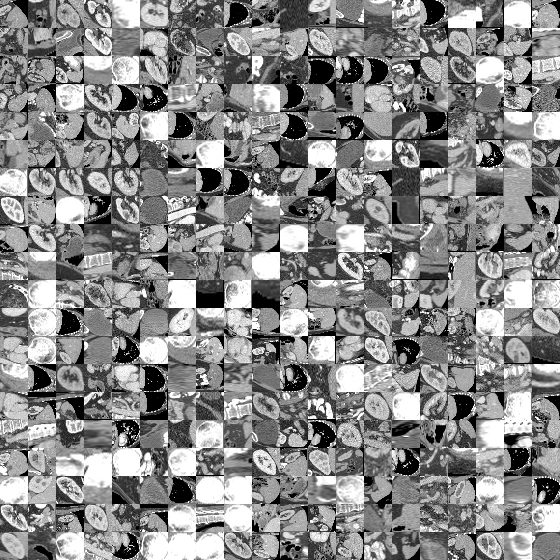

In [ ]:
frames = train_dataset.montage(length=20, save_folder="tmp/")

frames[10]

# We then check a 3D dataset with size 64x64x64

In [ ]:
data_flag = 'organmnist3d'
download = True

info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

# load the data
train_dataset = DataClass(split='train', download=download, size=64)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

Using downloaded and verified file: /home/sr/.medmnist/organmnist3d_64.npz


In [ ]:
x, y = train_dataset[0]

print(x.shape, y.shape)

(1, 64, 64, 64) (1,)


In [ ]:
for x, y in train_loader:
    print(x.shape, y.shape)
    break

torch.Size([128, 1, 64, 64, 64]) torch.Size([128, 1])


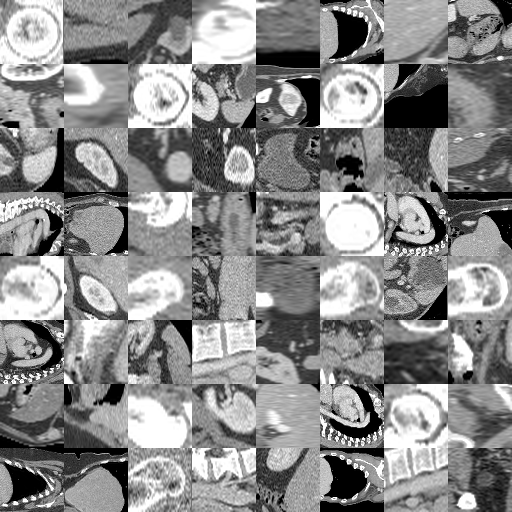

In [ ]:
frames = train_dataset.montage(length=8, save_folder="tmp/")

frames[10]

## Go and check the generated [gif](tmp/organmnist3d_64_train_montage.gif) ;)

# Check [EXTERNAL] [`MedMNIST/experiments`](https://github.com/MedMNIST/experiments)

Training and evaluation scripts to reproduce both 2D and 3D experiments in our paper, including PyTorch, auto-sklearn, AutoKeras and Google AutoML Vision together with their weights ;)